 # Lecture 13: Training deep neural networks

![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/1ftihrW-_2cIzCkA3TYScFgoOe1bQwTrT)

In [1]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2024-01-10 00:22:55


In [2]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_state(seed=42):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Vanishing and exploding gradients

Training typically relies on gradients.

*Vanishing gradients problem*: For deep networks, gradients in lower layers can become very small.  Hence, corresponding weights are not updated during training.

*Exploding gradients problem*: In some situations (typically recurrent neural networks) gradients can become very large.  Hence, weight updates are very large and the training algorithm may not converge.

In general deep neural networks can suffer from *unstable gradients*.

### Problematic activation functions

One common cause of vanishing gradients in the past was the use of the sigmoid activation function (and unit Gaussian initialisation).

In [3]:
def logit(z):
    return 1 / (1 + np.exp(-z))

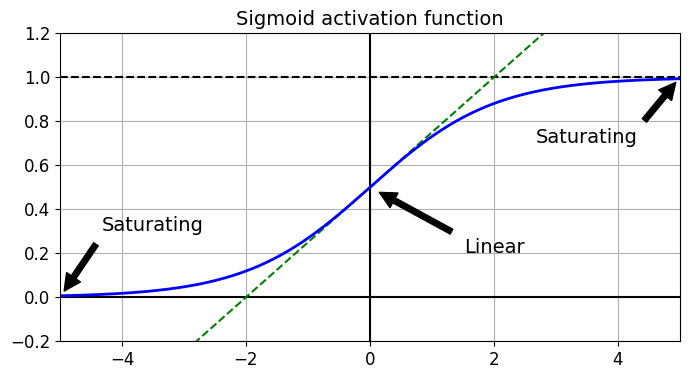

In [4]:
z = np.linspace(-5, 5, 200)
 
plt.figure(figsize=(8,4))
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

Variance of outputs grows at each layer.  Final layers essentially saturate.  Gradients on final layers then very small and when propagate gradients back with back-propagation then get vanishing gradients.

### Weight initialisation

To avoid this problem need signals and gradents to *not* decay as propagating through network.

Avoid decaying signals/gradients by promoting equal variance at outputs and inputs of layer.

Can be promoted by random initialisation of weights to follow Gaussian with standard deviation:

\begin{align}
\text{Sigmoid activation:} \quad\quad & \sigma = \sqrt{\frac{2}{n_{\rm inputs}+n_{\rm outputs}}} \\
\text{Hyperbolic tangent activation:} \quad\quad & \sigma = 4\sqrt{\frac{2}{n_{\rm inputs}+n_{\rm outputs}}} \\
\text{ReLU activation:} \quad\quad & \sigma = \sqrt{2}\sqrt{\frac{2}{n_{\rm inputs}+n_{\rm outputs}}} \\
\end{align}

where $n_{\rm inputs}$ and $n_{\rm outputs}$ are the number of input and output nodes, respectively, for the layer.

There are a lot of different weight initialisation strategies.

#### Weight initialisation in TensorFlow

In [5]:
import tensorflow as tf
from tensorflow import keras

2024-01-10 00:22:56.772636: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-10 00:22:56.822106: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-10 00:22:56.823186: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-01-10 00:22:57.633927: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

Can often simply set initialiser when defining layer.

In [7]:
reset_state()

keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

Or can set up a `VarianceScaling` object directly.

In [8]:
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init)

### Non-saturating activation functions

ReLU activation behaves much better than the sigmoid in deep networks since it does not saturate for positive values (and it is fast to compute).

However, the ReLU does suffer from the *dying neuron* problem.

In this senario neurons effectively die and only output zero.  The neuron is unlikely to come back to life since the gradient of the ReLU activation function is zero for negative inputs.

#### Leaky ReLU

The *leaky ReLU* avoids this problem and is defined by

$$
\text{LeakyReLU}_\alpha(z) = \max(\alpha z, z),
$$

where the hyperparameter $\alpha$ defines how much the leaky ReLU leaks (typically $\alpha=0.01$).

Let's plot the Leaky ReLU activation function for $\alpha=0.05$.

In [9]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

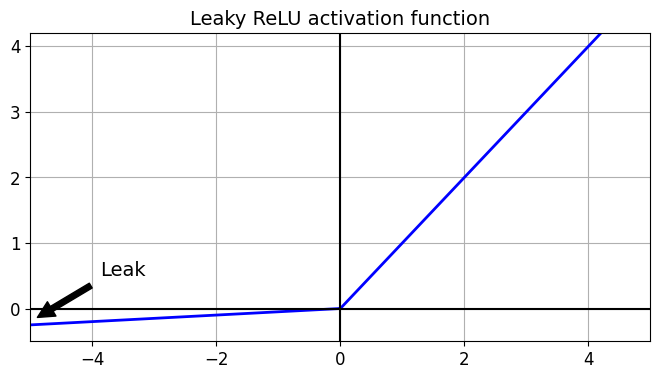

In [10]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(8,4))
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2]);

#### ELU

Another alternative is the *exponental linear unit* (ELU).

In [11]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z) # modify the negative input

Let's plot the ELU activation function for $\alpha=1$.

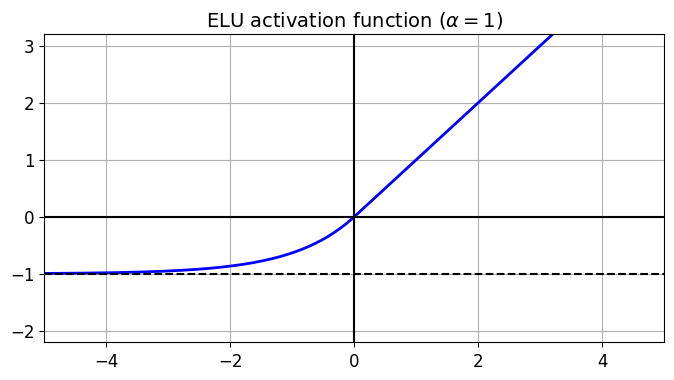

In [12]:
plt.figure(figsize=(8,4))
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2]);

Properties:
- Non-zero gradient for $z<0$ to avoid dying neuron issue.
- Smooth so gradients well defined.
- But is slower to compute.

#### Activations functions in TensorFlow

TensorFlow supports a lot of activation functions.

In [13]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'mish',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

Can again simply set when definiting layer or can construct directly.

In [14]:
reset_state()
keras.layers.Dense(10, activation="elu", name="hidden1")

In [15]:
reset_state()
keras.layers.Dense(10, activation=keras.layers.Activation("elu"), name="hidden1")

## Batch normalisation

While weight normalisation can reduce gradient problems at the beginning of training, it does not guarantee that these problems won't resurface during training.

*Batch normalisation* adds normalisation during training to address these issues.

Consists of zero-centering and normalising inputs just before the activation function, followed by shifting and scaling the result.  The shift and scale are considered additional parameters that are learnt during training.

This approach allows training to select the appropriate scale and shift (mean) for each layer.

The mean and standard deviation of the unnormalised inputs are computed for each mini-batch, hence the name *batch normalisation*.

When the trained network is applied to the test set there are no batches, so instead a running mean and standard deviation computed on the *training* set are used.

### Batch normalisation in TensorFlow

In [16]:
reset_state()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[28, 28]), keras.layers.BatchNormalization(),
keras.layers.Dense(n_hidden1, activation="elu", kernel_initializer="he_normal"), keras.layers.BatchNormalization(),
keras.layers.Dense(n_hidden2, activation="elu", kernel_initializer="he_normal"), keras.layers.BatchNormalization(),
keras.layers.Dense(n_outputs, activation="softmax")
])

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 flatten (Flatten)           (None, 784)               0         


 batch_normalization (Batch  (None, 784)               3136      


 Normalization)                                                  


 dense (Dense)               (None, 300)               235500    


 batch_normalization_1 (Bat  (None, 300)               1200      


 chNormalization)                                                


 dense_1 (Dense)             (None, 100)               30100     


 batch_normalization_2 (Bat  (None, 100)               400       


 chNormalization)                                                


 dense_2 (Dense)             (None, 10)                1010      


Total params: 271346 (1.04 MB)


Trainable params: 268978 (1.03 MB)


Non-trainable params: 2368 (9.25 KB)


_________________________________________________________________


In [17]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

**Exercises:** *You can now complete Exercise 1 in the exercises associated with this lecture.*

## Pretraining and transfer learning

A deep network trained for one task can often be adapted for a similar task.

Reuse lower layers of network trained for another task.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture13_Images/transfer_learning.png" width="700px" style="display:block; margin:auto"/>

[Credit: Geron]

For transfer learning to be successful the data must have similar low-level features.

### Reusing a Keras model

Let's work through a transfer learning example.

Split the fashion MNIST training set into two:
* `X_train_A`: all images of all items, except sandals and shirts (classes 5 and 6).
* `X_train_B`: first 200 images of sandals or shirts.

The validation set and the test set are split similarly, but without restricting the number of images.

Dataset B corresponds to a simple problem (binary classification) but we only have a small number of training instances. 

Dataset A corresponds to a more difficult problem (classification between 8 classes) but we have much more data.

We will attempt to transfer knowledge from setting A to B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). 

Aside: Note that only patterns that occur in the same location can be reused since we are using `Dense` layers (CNNs will be much more effective in tranferring information detected anywhere in the image due to their translational equivariance properties, as we'll see in the CNN lecture).

#### Set up data

In [18]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6] # y_A = (y != 5 & y != 6)
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [19]:
X_train_A.shape, X_train_B.shape

((43986, 28, 28), (200, 28, 28))

In [20]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [21]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

#### Define, compile, fit and save model on dataset A

In [22]:
reset_state()
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax")) # 8 classes -> 8 outputs

In [23]:
model_A.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 flatten (Flatten)           (None, 784)               0         


 dense (Dense)               (None, 300)               235500    


 dense_1 (Dense)             (None, 100)               30100     


 dense_2 (Dense)             (None, 50)                5050      


 dense_3 (Dense)             (None, 50)                2550      


 dense_4 (Dense)             (None, 50)                2550      


 dense_5 (Dense)             (None, 8)                 408       


Total params: 276158 (1.05 MB)


Trainable params: 276158 (1.05 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [24]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.legacy.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [25]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20



   1/1375 [..............................] - ETA: 8:50 - loss: 2.8891 - accuracy: 0.0938


  27/1375 [..............................] - ETA: 2s - loss: 2.1061 - accuracy: 0.2025  


  51/1375 [>.............................] - ETA: 2s - loss: 1.8194 - accuracy: 0.3333


  77/1375 [>.............................] - ETA: 2s - loss: 1.6347 - accuracy: 0.4217


 106/1375 [=>............................] - ETA: 2s - loss: 1.4854 - accuracy: 0.4844


 133/1375 [=>............................] - ETA: 2s - loss: 1.3878 - accuracy: 0.5221


 159/1375 [==>...........................] - ETA: 2s - loss: 1.3089 - accuracy: 0.5584


 184/1375 [===>..........................] - ETA: 2s - loss: 1.2474 - accuracy: 0.5851


 208/1375 [===>..........................] - ETA: 2s - loss: 1.1923 - accuracy: 0.6074


 234/1375 [====>.........................] - ETA: 2s - loss: 1.1401 - accuracy: 0.6274


 263/1375 [====>.........................] - ETA: 2s - loss: 1.0932 - accuracy: 0.6434


 287/1375 [=====>........................] - ETA: 2s - loss: 1.0595 - accuracy: 0.6556


 314/1375 [=====>........................] - ETA: 2s - loss: 1.0273 - accuracy: 0.6670


 342/1375 [======>.......................] - ETA: 2s - loss: 0.9975 - accuracy: 0.6765


 348/1375 [======>.......................] - ETA: 2s - loss: 0.9916 - accuracy: 0.6783


 376/1375 [=======>......................] - ETA: 2s - loss: 0.9658 - accuracy: 0.6857


 401/1375 [=======>......................] - ETA: 2s - loss: 0.9428 - accuracy: 0.6928


 429/1375 [========>.....................] - ETA: 2s - loss: 0.9203 - accuracy: 0.7001


 458/1375 [========>.....................] - ETA: 1s - loss: 0.8979 - accuracy: 0.7072


 483/1375 [=========>....................] - ETA: 1s - loss: 0.8822 - accuracy: 0.7129


 510/1375 [==========>...................] - ETA: 1s - loss: 0.8628 - accuracy: 0.7191


 535/1375 [==========>...................] - ETA: 1s - loss: 0.8474 - accuracy: 0.7240


 559/1375 [===========>..................] - ETA: 1s - loss: 0.8329 - accuracy: 0.7289


 585/1375 [===========>..................] - ETA: 1s - loss: 0.8200 - accuracy: 0.7332


 613/1375 [============>.................] - ETA: 1s - loss: 0.8051 - accuracy: 0.7376


 638/1375 [============>.................] - ETA: 1s - loss: 0.7942 - accuracy: 0.7404


 661/1375 [=============>................] - ETA: 1s - loss: 0.7835 - accuracy: 0.7439


 688/1375 [==============>...............] - ETA: 1s - loss: 0.7716 - accuracy: 0.7477


 715/1375 [==============>...............] - ETA: 1s - loss: 0.7595 - accuracy: 0.7521


 741/1375 [===============>..............] - ETA: 1s - loss: 0.7483 - accuracy: 0.7560


 767/1375 [===============>..............] - ETA: 1s - loss: 0.7392 - accuracy: 0.7586


 792/1375 [================>.............] - ETA: 1s - loss: 0.7296 - accuracy: 0.7611


 818/1375 [================>.............] - ETA: 1s - loss: 0.7198 - accuracy: 0.7644


 847/1375 [=================>............] - ETA: 1s - loss: 0.7112 - accuracy: 0.7668


 874/1375 [==================>...........] - ETA: 1s - loss: 0.7028 - accuracy: 0.7695


 898/1375 [==================>...........] - ETA: 0s - loss: 0.6958 - accuracy: 0.7717


 924/1375 [===================>..........] - ETA: 0s - loss: 0.6890 - accuracy: 0.7740


 950/1375 [===================>..........] - ETA: 0s - loss: 0.6825 - accuracy: 0.7760


 975/1375 [====================>.........] - ETA: 0s - loss: 0.6766 - accuracy: 0.7777


1002/1375 [====================>.........] - ETA: 0s - loss: 0.6701 - accuracy: 0.7794


1030/1375 [=====================>........] - ETA: 0s - loss: 0.6628 - accuracy: 0.7818


1056/1375 [======================>.......] - ETA: 0s - loss: 0.6579 - accuracy: 0.7834


1080/1375 [======================>.......] - ETA: 0s - loss: 0.6524 - accuracy: 0.7851


1105/1375 [=======================>......] - ETA: 0s - loss: 0.6463 - accuracy: 0.7868


1131/1375 [=======================>......] - ETA: 0s - loss: 0.6409 - accuracy: 0.7887


1156/1375 [========================>.....] - ETA: 0s - loss: 0.6350 - accuracy: 0.7907


1182/1375 [========================>.....] - ETA: 0s - loss: 0.6301 - accuracy: 0.7922


1210/1375 [=========================>....] - ETA: 0s - loss: 0.6243 - accuracy: 0.7942


1235/1375 [=========================>....] - ETA: 0s - loss: 0.6198 - accuracy: 0.7955


1263/1375 [==========================>...] - ETA: 0s - loss: 0.6152 - accuracy: 0.7970


1290/1375 [===========================>..] - ETA: 0s - loss: 0.6104 - accuracy: 0.7984


1314/1375 [===========================>..] - ETA: 0s - loss: 0.6067 - accuracy: 0.7996


1339/1375 [============================>.] - ETA: 0s - loss: 0.6028 - accuracy: 0.8008


1364/1375 [============================>.] - ETA: 0s - loss: 0.5995 - accuracy: 0.8020


1375/1375 [==============================] - 4s 2ms/step - loss: 0.5978 - accuracy: 0.8023 - val_loss: 0.3936 - val_accuracy: 0.8590


Epoch 2/20



   1/1375 [..............................] - ETA: 4s - loss: 0.4284 - accuracy: 0.8750


  29/1375 [..............................] - ETA: 2s - loss: 0.3657 - accuracy: 0.8825


  54/1375 [>.............................] - ETA: 2s - loss: 0.3820 - accuracy: 0.8681


  79/1375 [>.............................] - ETA: 2s - loss: 0.3866 - accuracy: 0.8651


 104/1375 [=>............................] - ETA: 2s - loss: 0.3822 - accuracy: 0.8669


 130/1375 [=>............................] - ETA: 2s - loss: 0.3815 - accuracy: 0.8661


 156/1375 [==>...........................] - ETA: 2s - loss: 0.3802 - accuracy: 0.8666


 184/1375 [===>..........................] - ETA: 2s - loss: 0.3829 - accuracy: 0.8658


 210/1375 [===>..........................] - ETA: 2s - loss: 0.3811 - accuracy: 0.8667


 239/1375 [====>.........................] - ETA: 2s - loss: 0.3803 - accuracy: 0.8681


 268/1375 [====>.........................] - ETA: 2s - loss: 0.3772 - accuracy: 0.8689


 297/1375 [=====>........................] - ETA: 2s - loss: 0.3749 - accuracy: 0.8692


 327/1375 [======>.......................] - ETA: 1s - loss: 0.3748 - accuracy: 0.8696


 353/1375 [======>.......................] - ETA: 1s - loss: 0.3762 - accuracy: 0.8692


 377/1375 [=======>......................] - ETA: 1s - loss: 0.3750 - accuracy: 0.8689


 404/1375 [=======>......................] - ETA: 1s - loss: 0.3741 - accuracy: 0.8690


 432/1375 [========>.....................] - ETA: 1s - loss: 0.3736 - accuracy: 0.8696


 458/1375 [========>.....................] - ETA: 1s - loss: 0.3732 - accuracy: 0.8699


 485/1375 [=========>....................] - ETA: 1s - loss: 0.3730 - accuracy: 0.8701


 511/1375 [==========>...................] - ETA: 1s - loss: 0.3723 - accuracy: 0.8708


 536/1375 [==========>...................] - ETA: 1s - loss: 0.3726 - accuracy: 0.8704


 560/1375 [===========>..................] - ETA: 1s - loss: 0.3717 - accuracy: 0.8706


 583/1375 [===========>..................] - ETA: 1s - loss: 0.3714 - accuracy: 0.8710


 610/1375 [============>.................] - ETA: 1s - loss: 0.3697 - accuracy: 0.8721


 639/1375 [============>.................] - ETA: 1s - loss: 0.3704 - accuracy: 0.8717


 664/1375 [=============>................] - ETA: 1s - loss: 0.3688 - accuracy: 0.8719


 693/1375 [==============>...............] - ETA: 1s - loss: 0.3691 - accuracy: 0.8713


 720/1375 [==============>...............] - ETA: 1s - loss: 0.3693 - accuracy: 0.8708


 747/1375 [===============>..............] - ETA: 1s - loss: 0.3686 - accuracy: 0.8713


 776/1375 [===============>..............] - ETA: 1s - loss: 0.3695 - accuracy: 0.8713


 802/1375 [================>.............] - ETA: 1s - loss: 0.3684 - accuracy: 0.8720


 830/1375 [=================>............] - ETA: 1s - loss: 0.3682 - accuracy: 0.8720


 856/1375 [=================>............] - ETA: 0s - loss: 0.3678 - accuracy: 0.8722


 885/1375 [==================>...........] - ETA: 0s - loss: 0.3665 - accuracy: 0.8725


 914/1375 [==================>...........] - ETA: 0s - loss: 0.3642 - accuracy: 0.8736


 942/1375 [===================>..........] - ETA: 0s - loss: 0.3632 - accuracy: 0.8739


 967/1375 [====================>.........] - ETA: 0s - loss: 0.3622 - accuracy: 0.8743


 991/1375 [====================>.........] - ETA: 0s - loss: 0.3617 - accuracy: 0.8744


1018/1375 [=====================>........] - ETA: 0s - loss: 0.3613 - accuracy: 0.8745


1045/1375 [=====================>........] - ETA: 0s - loss: 0.3610 - accuracy: 0.8746


1074/1375 [======================>.......] - ETA: 0s - loss: 0.3601 - accuracy: 0.8750


1101/1375 [=======================>......] - ETA: 0s - loss: 0.3589 - accuracy: 0.8755


1126/1375 [=======================>......] - ETA: 0s - loss: 0.3579 - accuracy: 0.8760


1151/1375 [========================>.....] - ETA: 0s - loss: 0.3573 - accuracy: 0.8763


1181/1375 [========================>.....] - ETA: 0s - loss: 0.3564 - accuracy: 0.8768


1211/1375 [=========================>....] - ETA: 0s - loss: 0.3560 - accuracy: 0.8768


1241/1375 [==========================>...] - ETA: 0s - loss: 0.3552 - accuracy: 0.8770


1267/1375 [==========================>...] - ETA: 0s - loss: 0.3542 - accuracy: 0.8773


1291/1375 [===========================>..] - ETA: 0s - loss: 0.3541 - accuracy: 0.8773


1316/1375 [===========================>..] - ETA: 0s - loss: 0.3530 - accuracy: 0.8778


1342/1375 [============================>.] - ETA: 0s - loss: 0.3519 - accuracy: 0.8784


1371/1375 [============================>.] - ETA: 0s - loss: 0.3519 - accuracy: 0.8785


1375/1375 [==============================] - 3s 2ms/step - loss: 0.3519 - accuracy: 0.8784 - val_loss: 0.3242 - val_accuracy: 0.8889


Epoch 3/20



   1/1375 [..............................] - ETA: 3s - loss: 0.3832 - accuracy: 0.9375


  29/1375 [..............................] - ETA: 2s - loss: 0.3219 - accuracy: 0.8836


  55/1375 [>.............................] - ETA: 2s - loss: 0.3357 - accuracy: 0.8858


  82/1375 [>.............................] - ETA: 2s - loss: 0.3225 - accuracy: 0.8895


 109/1375 [=>............................] - ETA: 2s - loss: 0.3199 - accuracy: 0.8902


 137/1375 [=>............................] - ETA: 2s - loss: 0.3153 - accuracy: 0.8917


 163/1375 [==>...........................] - ETA: 2s - loss: 0.3106 - accuracy: 0.8928


 185/1375 [===>..........................] - ETA: 2s - loss: 0.3111 - accuracy: 0.8943


 213/1375 [===>..........................] - ETA: 2s - loss: 0.3119 - accuracy: 0.8942


 242/1375 [====>.........................] - ETA: 2s - loss: 0.3122 - accuracy: 0.8946


 268/1375 [====>.........................] - ETA: 2s - loss: 0.3154 - accuracy: 0.8928


 294/1375 [=====>........................] - ETA: 2s - loss: 0.3163 - accuracy: 0.8926


 322/1375 [======>.......................] - ETA: 2s - loss: 0.3145 - accuracy: 0.8932


 347/1375 [======>.......................] - ETA: 1s - loss: 0.3151 - accuracy: 0.8929


 374/1375 [=======>......................] - ETA: 1s - loss: 0.3147 - accuracy: 0.8926


 402/1375 [=======>......................] - ETA: 1s - loss: 0.3129 - accuracy: 0.8931


 432/1375 [========>.....................] - ETA: 1s - loss: 0.3119 - accuracy: 0.8932


 459/1375 [=========>....................] - ETA: 1s - loss: 0.3104 - accuracy: 0.8936


 489/1375 [=========>....................] - ETA: 1s - loss: 0.3126 - accuracy: 0.8929


 518/1375 [==========>...................] - ETA: 1s - loss: 0.3128 - accuracy: 0.8929


 543/1375 [==========>...................] - ETA: 1s - loss: 0.3137 - accuracy: 0.8927


 573/1375 [===========>..................] - ETA: 1s - loss: 0.3139 - accuracy: 0.8925


 600/1375 [============>.................] - ETA: 1s - loss: 0.3144 - accuracy: 0.8922


 626/1375 [============>.................] - ETA: 1s - loss: 0.3145 - accuracy: 0.8921


 650/1375 [=============>................] - ETA: 1s - loss: 0.3145 - accuracy: 0.8918


 673/1375 [=============>................] - ETA: 1s - loss: 0.3145 - accuracy: 0.8918


 697/1375 [==============>...............] - ETA: 1s - loss: 0.3145 - accuracy: 0.8918


 725/1375 [==============>...............] - ETA: 1s - loss: 0.3141 - accuracy: 0.8917


 756/1375 [===============>..............] - ETA: 1s - loss: 0.3147 - accuracy: 0.8911


 784/1375 [================>.............] - ETA: 1s - loss: 0.3157 - accuracy: 0.8909


 810/1375 [================>.............] - ETA: 1s - loss: 0.3171 - accuracy: 0.8910


 834/1375 [=================>............] - ETA: 1s - loss: 0.3156 - accuracy: 0.8914


 862/1375 [=================>............] - ETA: 0s - loss: 0.3147 - accuracy: 0.8919


 889/1375 [==================>...........] - ETA: 0s - loss: 0.3150 - accuracy: 0.8916


 913/1375 [==================>...........] - ETA: 0s - loss: 0.3148 - accuracy: 0.8917


 935/1375 [===================>..........] - ETA: 0s - loss: 0.3151 - accuracy: 0.8916


 961/1375 [===================>..........] - ETA: 0s - loss: 0.3138 - accuracy: 0.8918


 991/1375 [====================>.........] - ETA: 0s - loss: 0.3149 - accuracy: 0.8913


1019/1375 [=====================>........] - ETA: 0s - loss: 0.3147 - accuracy: 0.8914


1045/1375 [=====================>........] - ETA: 0s - loss: 0.3150 - accuracy: 0.8911


1075/1375 [======================>.......] - ETA: 0s - loss: 0.3146 - accuracy: 0.8911


1102/1375 [=======================>......] - ETA: 0s - loss: 0.3141 - accuracy: 0.8912


1130/1375 [=======================>......] - ETA: 0s - loss: 0.3138 - accuracy: 0.8910


1155/1375 [========================>.....] - ETA: 0s - loss: 0.3133 - accuracy: 0.8912


1180/1375 [========================>.....] - ETA: 0s - loss: 0.3139 - accuracy: 0.8909


1209/1375 [=========================>....] - ETA: 0s - loss: 0.3144 - accuracy: 0.8907


1236/1375 [=========================>....] - ETA: 0s - loss: 0.3137 - accuracy: 0.8911


1265/1375 [==========================>...] - ETA: 0s - loss: 0.3138 - accuracy: 0.8910


1290/1375 [===========================>..] - ETA: 0s - loss: 0.3135 - accuracy: 0.8912


1319/1375 [===========================>..] - ETA: 0s - loss: 0.3130 - accuracy: 0.8914


1348/1375 [============================>.] - ETA: 0s - loss: 0.3136 - accuracy: 0.8911


1375/1375 [==============================] - 3s 2ms/step - loss: 0.3132 - accuracy: 0.8914 - val_loss: 0.2955 - val_accuracy: 0.9006


Epoch 4/20



   1/1375 [..............................] - ETA: 3s - loss: 0.2446 - accuracy: 0.9375


  28/1375 [..............................] - ETA: 2s - loss: 0.3079 - accuracy: 0.8984


  54/1375 [>.............................] - ETA: 2s - loss: 0.3117 - accuracy: 0.8993


  79/1375 [>.............................] - ETA: 2s - loss: 0.3132 - accuracy: 0.8932


 105/1375 [=>............................] - ETA: 2s - loss: 0.3167 - accuracy: 0.8899


 131/1375 [=>............................] - ETA: 2s - loss: 0.3214 - accuracy: 0.8898


 160/1375 [==>...........................] - ETA: 2s - loss: 0.3201 - accuracy: 0.8896


 187/1375 [===>..........................] - ETA: 2s - loss: 0.3148 - accuracy: 0.8909


 216/1375 [===>..........................] - ETA: 2s - loss: 0.3158 - accuracy: 0.8892


 240/1375 [====>.........................] - ETA: 2s - loss: 0.3166 - accuracy: 0.8891


 267/1375 [====>.........................] - ETA: 2s - loss: 0.3166 - accuracy: 0.8882


 292/1375 [=====>........................] - ETA: 2s - loss: 0.3165 - accuracy: 0.8891


 317/1375 [=====>........................] - ETA: 2s - loss: 0.3134 - accuracy: 0.8912


 344/1375 [======>.......................] - ETA: 1s - loss: 0.3108 - accuracy: 0.8918


 374/1375 [=======>......................] - ETA: 1s - loss: 0.3094 - accuracy: 0.8928


 402/1375 [=======>......................] - ETA: 1s - loss: 0.3069 - accuracy: 0.8932


 430/1375 [========>.....................] - ETA: 1s - loss: 0.3045 - accuracy: 0.8942


 456/1375 [========>.....................] - ETA: 1s - loss: 0.3032 - accuracy: 0.8944


 482/1375 [=========>....................] - ETA: 1s - loss: 0.3023 - accuracy: 0.8953


 512/1375 [==========>...................] - ETA: 1s - loss: 0.3003 - accuracy: 0.8964


 541/1375 [==========>...................] - ETA: 1s - loss: 0.2988 - accuracy: 0.8969


 567/1375 [===========>..................] - ETA: 1s - loss: 0.2968 - accuracy: 0.8975


 592/1375 [===========>..................] - ETA: 1s - loss: 0.2966 - accuracy: 0.8973


 619/1375 [============>.................] - ETA: 1s - loss: 0.2976 - accuracy: 0.8972


 646/1375 [=============>................] - ETA: 1s - loss: 0.2967 - accuracy: 0.8974


 672/1375 [=============>................] - ETA: 1s - loss: 0.2957 - accuracy: 0.8981


 698/1375 [==============>...............] - ETA: 1s - loss: 0.2968 - accuracy: 0.8980


 726/1375 [==============>...............] - ETA: 1s - loss: 0.2970 - accuracy: 0.8977


 752/1375 [===============>..............] - ETA: 1s - loss: 0.2959 - accuracy: 0.8985


 781/1375 [================>.............] - ETA: 1s - loss: 0.2944 - accuracy: 0.8986


 807/1375 [================>.............] - ETA: 1s - loss: 0.2952 - accuracy: 0.8985


 835/1375 [=================>............] - ETA: 1s - loss: 0.2962 - accuracy: 0.8983


 862/1375 [=================>............] - ETA: 0s - loss: 0.2956 - accuracy: 0.8986


 887/1375 [==================>...........] - ETA: 0s - loss: 0.2951 - accuracy: 0.8988


 916/1375 [==================>...........] - ETA: 0s - loss: 0.2947 - accuracy: 0.8987


 945/1375 [===================>..........] - ETA: 0s - loss: 0.2959 - accuracy: 0.8986


 975/1375 [====================>.........] - ETA: 0s - loss: 0.2952 - accuracy: 0.8986


1003/1375 [====================>.........] - ETA: 0s - loss: 0.2946 - accuracy: 0.8990


1028/1375 [=====================>........] - ETA: 0s - loss: 0.2947 - accuracy: 0.8990


1056/1375 [======================>.......] - ETA: 0s - loss: 0.2941 - accuracy: 0.8992


1081/1375 [======================>.......] - ETA: 0s - loss: 0.2932 - accuracy: 0.8998


1108/1375 [=======================>......] - ETA: 0s - loss: 0.2936 - accuracy: 0.8996


1137/1375 [=======================>......] - ETA: 0s - loss: 0.2943 - accuracy: 0.8994


1162/1375 [========================>.....] - ETA: 0s - loss: 0.2940 - accuracy: 0.8994


1188/1375 [========================>.....] - ETA: 0s - loss: 0.2939 - accuracy: 0.8995


1218/1375 [=========================>....] - ETA: 0s - loss: 0.2935 - accuracy: 0.8994


1248/1375 [==========================>...] - ETA: 0s - loss: 0.2946 - accuracy: 0.8993


1274/1375 [==========================>...] - ETA: 0s - loss: 0.2949 - accuracy: 0.8992


1299/1375 [===========================>..] - ETA: 0s - loss: 0.2939 - accuracy: 0.8994


1323/1375 [===========================>..] - ETA: 0s - loss: 0.2941 - accuracy: 0.8995


1351/1375 [============================>.] - ETA: 0s - loss: 0.2941 - accuracy: 0.8994


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2939 - accuracy: 0.8995 - val_loss: 0.2830 - val_accuracy: 0.9053


Epoch 5/20



   1/1375 [..............................] - ETA: 4s - loss: 0.4527 - accuracy: 0.8125


  29/1375 [..............................] - ETA: 2s - loss: 0.2789 - accuracy: 0.9095


  56/1375 [>.............................] - ETA: 2s - loss: 0.2719 - accuracy: 0.9102


  81/1375 [>.............................] - ETA: 2s - loss: 0.2689 - accuracy: 0.9101


 108/1375 [=>............................] - ETA: 2s - loss: 0.2623 - accuracy: 0.9094


 134/1375 [=>............................] - ETA: 2s - loss: 0.2716 - accuracy: 0.9065


 161/1375 [==>...........................] - ETA: 2s - loss: 0.2679 - accuracy: 0.9086


 185/1375 [===>..........................] - ETA: 2s - loss: 0.2638 - accuracy: 0.9096


 211/1375 [===>..........................] - ETA: 2s - loss: 0.2638 - accuracy: 0.9104


 240/1375 [====>.........................] - ETA: 2s - loss: 0.2694 - accuracy: 0.9087


 267/1375 [====>.........................] - ETA: 2s - loss: 0.2706 - accuracy: 0.9086


 292/1375 [=====>........................] - ETA: 2s - loss: 0.2718 - accuracy: 0.9076


 321/1375 [======>.......................] - ETA: 2s - loss: 0.2701 - accuracy: 0.9089


 349/1375 [======>.......................] - ETA: 1s - loss: 0.2724 - accuracy: 0.9073


 374/1375 [=======>......................] - ETA: 1s - loss: 0.2737 - accuracy: 0.9066


 402/1375 [=======>......................] - ETA: 1s - loss: 0.2732 - accuracy: 0.9062


 430/1375 [========>.....................] - ETA: 1s - loss: 0.2732 - accuracy: 0.9057


 456/1375 [========>.....................] - ETA: 1s - loss: 0.2774 - accuracy: 0.9044


 485/1375 [=========>....................] - ETA: 1s - loss: 0.2767 - accuracy: 0.9046


 513/1375 [==========>...................] - ETA: 1s - loss: 0.2791 - accuracy: 0.9036


 542/1375 [==========>...................] - ETA: 1s - loss: 0.2809 - accuracy: 0.9034


 570/1375 [===========>..................] - ETA: 1s - loss: 0.2801 - accuracy: 0.9036


 600/1375 [============>.................] - ETA: 1s - loss: 0.2791 - accuracy: 0.9040


 630/1375 [============>.................] - ETA: 1s - loss: 0.2801 - accuracy: 0.9037


 659/1375 [=============>................] - ETA: 1s - loss: 0.2809 - accuracy: 0.9038


 685/1375 [=============>................] - ETA: 1s - loss: 0.2825 - accuracy: 0.9033


 712/1375 [==============>...............] - ETA: 1s - loss: 0.2825 - accuracy: 0.9032


 736/1375 [===============>..............] - ETA: 1s - loss: 0.2828 - accuracy: 0.9029


 763/1375 [===============>..............] - ETA: 1s - loss: 0.2824 - accuracy: 0.9029


 792/1375 [================>.............] - ETA: 1s - loss: 0.2827 - accuracy: 0.9028


 819/1375 [================>.............] - ETA: 1s - loss: 0.2827 - accuracy: 0.9029


 848/1375 [=================>............] - ETA: 0s - loss: 0.2840 - accuracy: 0.9028


 877/1375 [==================>...........] - ETA: 0s - loss: 0.2845 - accuracy: 0.9026


 899/1375 [==================>...........] - ETA: 0s - loss: 0.2834 - accuracy: 0.9029


 924/1375 [===================>..........] - ETA: 0s - loss: 0.2837 - accuracy: 0.9026


 949/1375 [===================>..........] - ETA: 0s - loss: 0.2825 - accuracy: 0.9033


 979/1375 [====================>.........] - ETA: 0s - loss: 0.2824 - accuracy: 0.9033


1009/1375 [=====================>........] - ETA: 0s - loss: 0.2816 - accuracy: 0.9035


1034/1375 [=====================>........] - ETA: 0s - loss: 0.2815 - accuracy: 0.9034


1061/1375 [======================>.......] - ETA: 0s - loss: 0.2811 - accuracy: 0.9036


1091/1375 [======================>.......] - ETA: 0s - loss: 0.2818 - accuracy: 0.9035


1121/1375 [=======================>......] - ETA: 0s - loss: 0.2815 - accuracy: 0.9038


1151/1375 [========================>.....] - ETA: 0s - loss: 0.2815 - accuracy: 0.9039


1176/1375 [========================>.....] - ETA: 0s - loss: 0.2814 - accuracy: 0.9040


1202/1375 [=========================>....] - ETA: 0s - loss: 0.2818 - accuracy: 0.9039


1231/1375 [=========================>....] - ETA: 0s - loss: 0.2816 - accuracy: 0.9038


1256/1375 [==========================>...] - ETA: 0s - loss: 0.2813 - accuracy: 0.9038


1281/1375 [==========================>...] - ETA: 0s - loss: 0.2808 - accuracy: 0.9041


1306/1375 [===========================>..] - ETA: 0s - loss: 0.2808 - accuracy: 0.9042


1331/1375 [============================>.] - ETA: 0s - loss: 0.2813 - accuracy: 0.9043


1355/1375 [============================>.] - ETA: 0s - loss: 0.2813 - accuracy: 0.9042


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2811 - accuracy: 0.9043 - val_loss: 0.2721 - val_accuracy: 0.9083


Epoch 6/20



   1/1375 [..............................] - ETA: 3s - loss: 0.2328 - accuracy: 0.9062


  29/1375 [..............................] - ETA: 2s - loss: 0.2325 - accuracy: 0.9278


  55/1375 [>.............................] - ETA: 2s - loss: 0.2462 - accuracy: 0.9153


  84/1375 [>.............................] - ETA: 2s - loss: 0.2568 - accuracy: 0.9103


 112/1375 [=>............................] - ETA: 2s - loss: 0.2505 - accuracy: 0.9121


 136/1375 [=>............................] - ETA: 2s - loss: 0.2592 - accuracy: 0.9095


 161/1375 [==>...........................] - ETA: 2s - loss: 0.2650 - accuracy: 0.9059


 187/1375 [===>..........................] - ETA: 2s - loss: 0.2665 - accuracy: 0.9076


 210/1375 [===>..........................] - ETA: 2s - loss: 0.2659 - accuracy: 0.9082


 235/1375 [====>.........................] - ETA: 2s - loss: 0.2661 - accuracy: 0.9088


 263/1375 [====>.........................] - ETA: 2s - loss: 0.2699 - accuracy: 0.9092


 285/1375 [=====>........................] - ETA: 2s - loss: 0.2696 - accuracy: 0.9090


 310/1375 [=====>........................] - ETA: 2s - loss: 0.2689 - accuracy: 0.9092


 339/1375 [======>.......................] - ETA: 2s - loss: 0.2708 - accuracy: 0.9096


 365/1375 [======>.......................] - ETA: 1s - loss: 0.2711 - accuracy: 0.9097


 391/1375 [=======>......................] - ETA: 1s - loss: 0.2733 - accuracy: 0.9090


 415/1375 [========>.....................] - ETA: 1s - loss: 0.2737 - accuracy: 0.9082


 439/1375 [========>.....................] - ETA: 1s - loss: 0.2738 - accuracy: 0.9081


 465/1375 [=========>....................] - ETA: 1s - loss: 0.2737 - accuracy: 0.9077


 489/1375 [=========>....................] - ETA: 1s - loss: 0.2735 - accuracy: 0.9082


 515/1375 [==========>...................] - ETA: 1s - loss: 0.2733 - accuracy: 0.9078


 544/1375 [==========>...................] - ETA: 1s - loss: 0.2759 - accuracy: 0.9071


 572/1375 [===========>..................] - ETA: 1s - loss: 0.2774 - accuracy: 0.9070


 596/1375 [============>.................] - ETA: 1s - loss: 0.2765 - accuracy: 0.9076


 625/1375 [============>.................] - ETA: 1s - loss: 0.2743 - accuracy: 0.9082


 652/1375 [=============>................] - ETA: 1s - loss: 0.2743 - accuracy: 0.9082


 679/1375 [=============>................] - ETA: 1s - loss: 0.2733 - accuracy: 0.9081


 707/1375 [==============>...............] - ETA: 1s - loss: 0.2726 - accuracy: 0.9085


 735/1375 [===============>..............] - ETA: 1s - loss: 0.2737 - accuracy: 0.9081


 763/1375 [===============>..............] - ETA: 1s - loss: 0.2737 - accuracy: 0.9082


 790/1375 [================>.............] - ETA: 1s - loss: 0.2740 - accuracy: 0.9083


 818/1375 [================>.............] - ETA: 1s - loss: 0.2734 - accuracy: 0.9087


 847/1375 [=================>............] - ETA: 1s - loss: 0.2733 - accuracy: 0.9085


 877/1375 [==================>...........] - ETA: 0s - loss: 0.2726 - accuracy: 0.9087


 907/1375 [==================>...........] - ETA: 0s - loss: 0.2724 - accuracy: 0.9084


 935/1375 [===================>..........] - ETA: 0s - loss: 0.2733 - accuracy: 0.9082


 965/1375 [====================>.........] - ETA: 0s - loss: 0.2729 - accuracy: 0.9078


 993/1375 [====================>.........] - ETA: 0s - loss: 0.2738 - accuracy: 0.9074


1021/1375 [=====================>........] - ETA: 0s - loss: 0.2740 - accuracy: 0.9074


1049/1375 [=====================>........] - ETA: 0s - loss: 0.2728 - accuracy: 0.9077


1077/1375 [======================>.......] - ETA: 0s - loss: 0.2734 - accuracy: 0.9077


1103/1375 [=======================>......] - ETA: 0s - loss: 0.2735 - accuracy: 0.9075


1129/1375 [=======================>......] - ETA: 0s - loss: 0.2739 - accuracy: 0.9073


1158/1375 [========================>.....] - ETA: 0s - loss: 0.2739 - accuracy: 0.9072


1186/1375 [========================>.....] - ETA: 0s - loss: 0.2739 - accuracy: 0.9072


1213/1375 [=========================>....] - ETA: 0s - loss: 0.2736 - accuracy: 0.9073


1240/1375 [==========================>...] - ETA: 0s - loss: 0.2735 - accuracy: 0.9074


1267/1375 [==========================>...] - ETA: 0s - loss: 0.2732 - accuracy: 0.9076


1295/1375 [===========================>..] - ETA: 0s - loss: 0.2725 - accuracy: 0.9078


1323/1375 [===========================>..] - ETA: 0s - loss: 0.2724 - accuracy: 0.9078


1350/1375 [============================>.] - ETA: 0s - loss: 0.2718 - accuracy: 0.9080


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2717 - accuracy: 0.9078 - val_loss: 0.2693 - val_accuracy: 0.9081


Epoch 7/20



   1/1375 [..............................] - ETA: 6s - loss: 0.5773 - accuracy: 0.8750


  27/1375 [..............................] - ETA: 2s - loss: 0.2829 - accuracy: 0.9097


  53/1375 [>.............................] - ETA: 2s - loss: 0.2677 - accuracy: 0.9098


  81/1375 [>.............................] - ETA: 2s - loss: 0.2639 - accuracy: 0.9109


 109/1375 [=>............................] - ETA: 2s - loss: 0.2665 - accuracy: 0.9080


 135/1375 [=>............................] - ETA: 2s - loss: 0.2596 - accuracy: 0.9100


 165/1375 [==>...........................] - ETA: 2s - loss: 0.2598 - accuracy: 0.9110


 192/1375 [===>..........................] - ETA: 2s - loss: 0.2645 - accuracy: 0.9102


 219/1375 [===>..........................] - ETA: 2s - loss: 0.2644 - accuracy: 0.9104


 247/1375 [====>.........................] - ETA: 2s - loss: 0.2624 - accuracy: 0.9107


 274/1375 [====>.........................] - ETA: 2s - loss: 0.2642 - accuracy: 0.9108


 299/1375 [=====>........................] - ETA: 2s - loss: 0.2648 - accuracy: 0.9108


 325/1375 [======>.......................] - ETA: 1s - loss: 0.2604 - accuracy: 0.9133


 355/1375 [======>.......................] - ETA: 1s - loss: 0.2576 - accuracy: 0.9140


 385/1375 [=======>......................] - ETA: 1s - loss: 0.2573 - accuracy: 0.9141


 411/1375 [=======>......................] - ETA: 1s - loss: 0.2557 - accuracy: 0.9149


 437/1375 [========>.....................] - ETA: 1s - loss: 0.2574 - accuracy: 0.9138


 464/1375 [=========>....................] - ETA: 1s - loss: 0.2586 - accuracy: 0.9136


 490/1375 [=========>....................] - ETA: 1s - loss: 0.2577 - accuracy: 0.9140


 516/1375 [==========>...................] - ETA: 1s - loss: 0.2553 - accuracy: 0.9144


 542/1375 [==========>...................] - ETA: 1s - loss: 0.2550 - accuracy: 0.9144


 566/1375 [===========>..................] - ETA: 1s - loss: 0.2564 - accuracy: 0.9139


 595/1375 [===========>..................] - ETA: 1s - loss: 0.2584 - accuracy: 0.9132


 621/1375 [============>.................] - ETA: 1s - loss: 0.2566 - accuracy: 0.9139


 646/1375 [=============>................] - ETA: 1s - loss: 0.2566 - accuracy: 0.9139


 670/1375 [=============>................] - ETA: 1s - loss: 0.2580 - accuracy: 0.9134


 696/1375 [==============>...............] - ETA: 1s - loss: 0.2581 - accuracy: 0.9133


 725/1375 [==============>...............] - ETA: 1s - loss: 0.2594 - accuracy: 0.9128


 752/1375 [===============>..............] - ETA: 1s - loss: 0.2592 - accuracy: 0.9124


 776/1375 [===============>..............] - ETA: 1s - loss: 0.2594 - accuracy: 0.9118


 792/1375 [================>.............] - ETA: 1s - loss: 0.2597 - accuracy: 0.9118


 817/1375 [================>.............] - ETA: 1s - loss: 0.2599 - accuracy: 0.9118


 840/1375 [=================>............] - ETA: 1s - loss: 0.2603 - accuracy: 0.9117


 864/1375 [=================>............] - ETA: 0s - loss: 0.2595 - accuracy: 0.9121


 891/1375 [==================>...........] - ETA: 0s - loss: 0.2591 - accuracy: 0.9119


 919/1375 [===================>..........] - ETA: 0s - loss: 0.2601 - accuracy: 0.9114


 944/1375 [===================>..........] - ETA: 0s - loss: 0.2607 - accuracy: 0.9111


 968/1375 [====================>.........] - ETA: 0s - loss: 0.2616 - accuracy: 0.9108


 994/1375 [====================>.........] - ETA: 0s - loss: 0.2612 - accuracy: 0.9110


1020/1375 [=====================>........] - ETA: 0s - loss: 0.2619 - accuracy: 0.9107


1046/1375 [=====================>........] - ETA: 0s - loss: 0.2623 - accuracy: 0.9104


1071/1375 [======================>.......] - ETA: 0s - loss: 0.2629 - accuracy: 0.9100


1098/1375 [======================>.......] - ETA: 0s - loss: 0.2647 - accuracy: 0.9096


1123/1375 [=======================>......] - ETA: 0s - loss: 0.2647 - accuracy: 0.9098


1149/1375 [========================>.....] - ETA: 0s - loss: 0.2646 - accuracy: 0.9101


1174/1375 [========================>.....] - ETA: 0s - loss: 0.2643 - accuracy: 0.9099


1201/1375 [=========================>....] - ETA: 0s - loss: 0.2644 - accuracy: 0.9100


1226/1375 [=========================>....] - ETA: 0s - loss: 0.2641 - accuracy: 0.9102


1253/1375 [==========================>...] - ETA: 0s - loss: 0.2639 - accuracy: 0.9102


1278/1375 [==========================>...] - ETA: 0s - loss: 0.2642 - accuracy: 0.9102


1304/1375 [===========================>..] - ETA: 0s - loss: 0.2641 - accuracy: 0.9103


1329/1375 [===========================>..] - ETA: 0s - loss: 0.2638 - accuracy: 0.9103


1358/1375 [============================>.] - ETA: 0s - loss: 0.2636 - accuracy: 0.9107


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2636 - accuracy: 0.9107 - val_loss: 0.2666 - val_accuracy: 0.9076


Epoch 8/20



   1/1375 [..............................] - ETA: 4s - loss: 0.1498 - accuracy: 0.9375


  27/1375 [..............................] - ETA: 2s - loss: 0.2740 - accuracy: 0.9132


  56/1375 [>.............................] - ETA: 2s - loss: 0.2693 - accuracy: 0.9096


  84/1375 [>.............................] - ETA: 2s - loss: 0.2785 - accuracy: 0.9040


 109/1375 [=>............................] - ETA: 2s - loss: 0.2853 - accuracy: 0.8999


 135/1375 [=>............................] - ETA: 2s - loss: 0.2788 - accuracy: 0.9058


 160/1375 [==>...........................] - ETA: 2s - loss: 0.2699 - accuracy: 0.9070


 185/1375 [===>..........................] - ETA: 2s - loss: 0.2687 - accuracy: 0.9057


 211/1375 [===>..........................] - ETA: 2s - loss: 0.2692 - accuracy: 0.9049


 238/1375 [====>.........................] - ETA: 2s - loss: 0.2697 - accuracy: 0.9059


 268/1375 [====>.........................] - ETA: 2s - loss: 0.2684 - accuracy: 0.9071


 297/1375 [=====>........................] - ETA: 2s - loss: 0.2660 - accuracy: 0.9079


 326/1375 [======>.......................] - ETA: 1s - loss: 0.2676 - accuracy: 0.9073


 350/1375 [======>.......................] - ETA: 1s - loss: 0.2660 - accuracy: 0.9077


 379/1375 [=======>......................] - ETA: 1s - loss: 0.2682 - accuracy: 0.9066


 406/1375 [=======>......................] - ETA: 1s - loss: 0.2686 - accuracy: 0.9067


 432/1375 [========>.....................] - ETA: 1s - loss: 0.2669 - accuracy: 0.9076


 457/1375 [========>.....................] - ETA: 1s - loss: 0.2638 - accuracy: 0.9088


 484/1375 [=========>....................] - ETA: 1s - loss: 0.2649 - accuracy: 0.9087


 512/1375 [==========>...................] - ETA: 1s - loss: 0.2646 - accuracy: 0.9093


 538/1375 [==========>...................] - ETA: 1s - loss: 0.2625 - accuracy: 0.9103


 564/1375 [===========>..................] - ETA: 1s - loss: 0.2641 - accuracy: 0.9100


 591/1375 [===========>..................] - ETA: 1s - loss: 0.2622 - accuracy: 0.9110


 615/1375 [============>.................] - ETA: 1s - loss: 0.2627 - accuracy: 0.9106


 639/1375 [============>.................] - ETA: 1s - loss: 0.2625 - accuracy: 0.9107


 665/1375 [=============>................] - ETA: 1s - loss: 0.2611 - accuracy: 0.9115


 692/1375 [==============>...............] - ETA: 1s - loss: 0.2594 - accuracy: 0.9118


 721/1375 [==============>...............] - ETA: 1s - loss: 0.2594 - accuracy: 0.9117


 747/1375 [===============>..............] - ETA: 1s - loss: 0.2587 - accuracy: 0.9116


 774/1375 [===============>..............] - ETA: 1s - loss: 0.2590 - accuracy: 0.9115


 803/1375 [================>.............] - ETA: 1s - loss: 0.2608 - accuracy: 0.9110


 831/1375 [=================>............] - ETA: 1s - loss: 0.2598 - accuracy: 0.9115


 859/1375 [=================>............] - ETA: 0s - loss: 0.2589 - accuracy: 0.9119


 886/1375 [==================>...........] - ETA: 0s - loss: 0.2584 - accuracy: 0.9122


 912/1375 [==================>...........] - ETA: 0s - loss: 0.2594 - accuracy: 0.9119


 935/1375 [===================>..........] - ETA: 0s - loss: 0.2590 - accuracy: 0.9121


 961/1375 [===================>..........] - ETA: 0s - loss: 0.2587 - accuracy: 0.9120


 989/1375 [====================>.........] - ETA: 0s - loss: 0.2595 - accuracy: 0.9117


1016/1375 [=====================>........] - ETA: 0s - loss: 0.2590 - accuracy: 0.9119


1041/1375 [=====================>........] - ETA: 0s - loss: 0.2588 - accuracy: 0.9119


1067/1375 [======================>.......] - ETA: 0s - loss: 0.2584 - accuracy: 0.9124


1096/1375 [======================>.......] - ETA: 0s - loss: 0.2583 - accuracy: 0.9126


1122/1375 [=======================>......] - ETA: 0s - loss: 0.2591 - accuracy: 0.9125


1147/1375 [========================>.....] - ETA: 0s - loss: 0.2585 - accuracy: 0.9128


1172/1375 [========================>.....] - ETA: 0s - loss: 0.2587 - accuracy: 0.9127


1200/1375 [=========================>....] - ETA: 0s - loss: 0.2580 - accuracy: 0.9128


1228/1375 [=========================>....] - ETA: 0s - loss: 0.2584 - accuracy: 0.9128


1256/1375 [==========================>...] - ETA: 0s - loss: 0.2577 - accuracy: 0.9131


1284/1375 [===========================>..] - ETA: 0s - loss: 0.2577 - accuracy: 0.9132


1308/1375 [===========================>..] - ETA: 0s - loss: 0.2572 - accuracy: 0.9134


1333/1375 [============================>.] - ETA: 0s - loss: 0.2572 - accuracy: 0.9136


1362/1375 [============================>.] - ETA: 0s - loss: 0.2568 - accuracy: 0.9137


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2572 - accuracy: 0.9136 - val_loss: 0.2570 - val_accuracy: 0.9126


Epoch 9/20



   1/1375 [..............................] - ETA: 4s - loss: 0.1835 - accuracy: 0.9062


  29/1375 [..............................] - ETA: 2s - loss: 0.2600 - accuracy: 0.8966


  58/1375 [>.............................] - ETA: 2s - loss: 0.2755 - accuracy: 0.8987


  83/1375 [>.............................] - ETA: 2s - loss: 0.2640 - accuracy: 0.9032


 106/1375 [=>............................] - ETA: 2s - loss: 0.2603 - accuracy: 0.9080


 133/1375 [=>............................] - ETA: 2s - loss: 0.2573 - accuracy: 0.9086


 162/1375 [==>...........................] - ETA: 2s - loss: 0.2539 - accuracy: 0.9099


 186/1375 [===>..........................] - ETA: 2s - loss: 0.2507 - accuracy: 0.9121


 216/1375 [===>..........................] - ETA: 2s - loss: 0.2534 - accuracy: 0.9129


 243/1375 [====>.........................] - ETA: 2s - loss: 0.2535 - accuracy: 0.9115


 268/1375 [====>.........................] - ETA: 2s - loss: 0.2485 - accuracy: 0.9131


 298/1375 [=====>........................] - ETA: 2s - loss: 0.2475 - accuracy: 0.9138


 325/1375 [======>.......................] - ETA: 1s - loss: 0.2484 - accuracy: 0.9146


 351/1375 [======>.......................] - ETA: 1s - loss: 0.2522 - accuracy: 0.9138


 379/1375 [=======>......................] - ETA: 1s - loss: 0.2490 - accuracy: 0.9146


 404/1375 [=======>......................] - ETA: 1s - loss: 0.2514 - accuracy: 0.9140


 435/1375 [========>.....................] - ETA: 1s - loss: 0.2511 - accuracy: 0.9139


 461/1375 [=========>....................] - ETA: 1s - loss: 0.2522 - accuracy: 0.9136


 487/1375 [=========>....................] - ETA: 1s - loss: 0.2543 - accuracy: 0.9133


 512/1375 [==========>...................] - ETA: 1s - loss: 0.2535 - accuracy: 0.9136


 537/1375 [==========>...................] - ETA: 1s - loss: 0.2526 - accuracy: 0.9140


 561/1375 [===========>..................] - ETA: 1s - loss: 0.2521 - accuracy: 0.9144


 587/1375 [===========>..................] - ETA: 1s - loss: 0.2528 - accuracy: 0.9142


 611/1375 [============>.................] - ETA: 1s - loss: 0.2526 - accuracy: 0.9139


 640/1375 [============>.................] - ETA: 1s - loss: 0.2541 - accuracy: 0.9130


 666/1375 [=============>................] - ETA: 1s - loss: 0.2534 - accuracy: 0.9132


 693/1375 [==============>...............] - ETA: 1s - loss: 0.2536 - accuracy: 0.9131


 717/1375 [==============>...............] - ETA: 1s - loss: 0.2541 - accuracy: 0.9131


 741/1375 [===============>..............] - ETA: 1s - loss: 0.2530 - accuracy: 0.9135


 765/1375 [===============>..............] - ETA: 1s - loss: 0.2528 - accuracy: 0.9135


 791/1375 [================>.............] - ETA: 1s - loss: 0.2535 - accuracy: 0.9132


 819/1375 [================>.............] - ETA: 1s - loss: 0.2527 - accuracy: 0.9138


 850/1375 [=================>............] - ETA: 1s - loss: 0.2540 - accuracy: 0.9137


 877/1375 [==================>...........] - ETA: 0s - loss: 0.2532 - accuracy: 0.9140


 904/1375 [==================>...........] - ETA: 0s - loss: 0.2536 - accuracy: 0.9136


 929/1375 [===================>..........] - ETA: 0s - loss: 0.2538 - accuracy: 0.9136


 955/1375 [===================>..........] - ETA: 0s - loss: 0.2530 - accuracy: 0.9137


 982/1375 [====================>.........] - ETA: 0s - loss: 0.2525 - accuracy: 0.9138


1008/1375 [====================>.........] - ETA: 0s - loss: 0.2532 - accuracy: 0.9138


1034/1375 [=====================>........] - ETA: 0s - loss: 0.2531 - accuracy: 0.9139


1060/1375 [======================>.......] - ETA: 0s - loss: 0.2527 - accuracy: 0.9141


1089/1375 [======================>.......] - ETA: 0s - loss: 0.2523 - accuracy: 0.9142


1116/1375 [=======================>......] - ETA: 0s - loss: 0.2526 - accuracy: 0.9142


1142/1375 [=======================>......] - ETA: 0s - loss: 0.2523 - accuracy: 0.9143


1166/1375 [========================>.....] - ETA: 0s - loss: 0.2517 - accuracy: 0.9145


1195/1375 [=========================>....] - ETA: 0s - loss: 0.2517 - accuracy: 0.9147


1222/1375 [=========================>....] - ETA: 0s - loss: 0.2512 - accuracy: 0.9147


1247/1375 [==========================>...] - ETA: 0s - loss: 0.2508 - accuracy: 0.9149


1274/1375 [==========================>...] - ETA: 0s - loss: 0.2511 - accuracy: 0.9148


1299/1375 [===========================>..] - ETA: 0s - loss: 0.2517 - accuracy: 0.9144


1324/1375 [===========================>..] - ETA: 0s - loss: 0.2514 - accuracy: 0.9144


1351/1375 [============================>.] - ETA: 0s - loss: 0.2511 - accuracy: 0.9144


1375/1375 [==============================] - ETA: 0s - loss: 0.2517 - accuracy: 0.9144


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2517 - accuracy: 0.9144 - val_loss: 0.2537 - val_accuracy: 0.9126


Epoch 10/20



   1/1375 [..............................] - ETA: 4s - loss: 0.3150 - accuracy: 0.9375


  29/1375 [..............................] - ETA: 2s - loss: 0.2828 - accuracy: 0.9106


  56/1375 [>.............................] - ETA: 2s - loss: 0.2663 - accuracy: 0.9124


  81/1375 [>.............................] - ETA: 2s - loss: 0.2618 - accuracy: 0.9132


 106/1375 [=>............................] - ETA: 2s - loss: 0.2566 - accuracy: 0.9154


 131/1375 [=>............................] - ETA: 2s - loss: 0.2532 - accuracy: 0.9139


 161/1375 [==>...........................] - ETA: 2s - loss: 0.2585 - accuracy: 0.9107


 188/1375 [===>..........................] - ETA: 2s - loss: 0.2629 - accuracy: 0.9109


 219/1375 [===>..........................] - ETA: 2s - loss: 0.2584 - accuracy: 0.9137


 247/1375 [====>.........................] - ETA: 2s - loss: 0.2556 - accuracy: 0.9150


 273/1375 [====>.........................] - ETA: 2s - loss: 0.2558 - accuracy: 0.9147


 303/1375 [=====>........................] - ETA: 1s - loss: 0.2540 - accuracy: 0.9154


 330/1375 [======>.......................] - ETA: 1s - loss: 0.2530 - accuracy: 0.9163


 356/1375 [======>.......................] - ETA: 1s - loss: 0.2558 - accuracy: 0.9151


 382/1375 [=======>......................] - ETA: 1s - loss: 0.2550 - accuracy: 0.9157


 408/1375 [=======>......................] - ETA: 1s - loss: 0.2538 - accuracy: 0.9157


 435/1375 [========>.....................] - ETA: 1s - loss: 0.2539 - accuracy: 0.9153


 465/1375 [=========>....................] - ETA: 1s - loss: 0.2542 - accuracy: 0.9147


 491/1375 [=========>....................] - ETA: 1s - loss: 0.2519 - accuracy: 0.9155


 518/1375 [==========>...................] - ETA: 1s - loss: 0.2529 - accuracy: 0.9148


 544/1375 [==========>...................] - ETA: 1s - loss: 0.2520 - accuracy: 0.9149


 574/1375 [===========>..................] - ETA: 1s - loss: 0.2503 - accuracy: 0.9149


 601/1375 [============>.................] - ETA: 1s - loss: 0.2508 - accuracy: 0.9151


 625/1375 [============>.................] - ETA: 1s - loss: 0.2517 - accuracy: 0.9151


 655/1375 [=============>................] - ETA: 1s - loss: 0.2533 - accuracy: 0.9145


 683/1375 [=============>................] - ETA: 1s - loss: 0.2524 - accuracy: 0.9147


 707/1375 [==============>...............] - ETA: 1s - loss: 0.2527 - accuracy: 0.9146


 736/1375 [===============>..............] - ETA: 1s - loss: 0.2514 - accuracy: 0.9148


 766/1375 [===============>..............] - ETA: 1s - loss: 0.2532 - accuracy: 0.9140


 795/1375 [================>.............] - ETA: 1s - loss: 0.2535 - accuracy: 0.9140


 824/1375 [================>.............] - ETA: 1s - loss: 0.2521 - accuracy: 0.9144


 851/1375 [=================>............] - ETA: 0s - loss: 0.2518 - accuracy: 0.9144


 875/1375 [==================>...........] - ETA: 0s - loss: 0.2519 - accuracy: 0.9144


 903/1375 [==================>...........] - ETA: 0s - loss: 0.2509 - accuracy: 0.9151


 933/1375 [===================>..........] - ETA: 0s - loss: 0.2507 - accuracy: 0.9151


 960/1375 [===================>..........] - ETA: 0s - loss: 0.2513 - accuracy: 0.9149


 986/1375 [====================>.........] - ETA: 0s - loss: 0.2502 - accuracy: 0.9152


1012/1375 [=====================>........] - ETA: 0s - loss: 0.2489 - accuracy: 0.9156


1038/1375 [=====================>........] - ETA: 0s - loss: 0.2488 - accuracy: 0.9154


1065/1375 [======================>.......] - ETA: 0s - loss: 0.2482 - accuracy: 0.9156


1095/1375 [======================>.......] - ETA: 0s - loss: 0.2479 - accuracy: 0.9157


1125/1375 [=======================>......] - ETA: 0s - loss: 0.2476 - accuracy: 0.9158


1151/1375 [========================>.....] - ETA: 0s - loss: 0.2471 - accuracy: 0.9161


1177/1375 [========================>.....] - ETA: 0s - loss: 0.2470 - accuracy: 0.9162


1202/1375 [=========================>....] - ETA: 0s - loss: 0.2466 - accuracy: 0.9163


1230/1375 [=========================>....] - ETA: 0s - loss: 0.2467 - accuracy: 0.9163


1257/1375 [==========================>...] - ETA: 0s - loss: 0.2464 - accuracy: 0.9163


1287/1375 [===========================>..] - ETA: 0s - loss: 0.2467 - accuracy: 0.9159


1317/1375 [===========================>..] - ETA: 0s - loss: 0.2471 - accuracy: 0.9156


1343/1375 [============================>.] - ETA: 0s - loss: 0.2476 - accuracy: 0.9155


1369/1375 [============================>.] - ETA: 0s - loss: 0.2471 - accuracy: 0.9156


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2472 - accuracy: 0.9156 - val_loss: 0.2533 - val_accuracy: 0.9165


Epoch 11/20



   1/1375 [..............................] - ETA: 3s - loss: 0.5573 - accuracy: 0.7812


  29/1375 [..............................] - ETA: 2s - loss: 0.2315 - accuracy: 0.9246


  55/1375 [>.............................] - ETA: 2s - loss: 0.2344 - accuracy: 0.9239


  78/1375 [>.............................] - ETA: 2s - loss: 0.2354 - accuracy: 0.9239


 103/1375 [=>............................] - ETA: 2s - loss: 0.2356 - accuracy: 0.9217


 129/1375 [=>............................] - ETA: 2s - loss: 0.2446 - accuracy: 0.9188


 159/1375 [==>...........................] - ETA: 2s - loss: 0.2430 - accuracy: 0.9190


 188/1375 [===>..........................] - ETA: 2s - loss: 0.2422 - accuracy: 0.9184


 218/1375 [===>..........................] - ETA: 2s - loss: 0.2424 - accuracy: 0.9179


 247/1375 [====>.........................] - ETA: 2s - loss: 0.2483 - accuracy: 0.9161


 273/1375 [====>.........................] - ETA: 2s - loss: 0.2465 - accuracy: 0.9169


 299/1375 [=====>........................] - ETA: 2s - loss: 0.2447 - accuracy: 0.9180


 324/1375 [======>.......................] - ETA: 1s - loss: 0.2429 - accuracy: 0.9183


 351/1375 [======>.......................] - ETA: 1s - loss: 0.2444 - accuracy: 0.9176


 378/1375 [=======>......................] - ETA: 1s - loss: 0.2424 - accuracy: 0.9181


 405/1375 [=======>......................] - ETA: 1s - loss: 0.2431 - accuracy: 0.9180


 434/1375 [========>.....................] - ETA: 1s - loss: 0.2424 - accuracy: 0.9172


 463/1375 [=========>....................] - ETA: 1s - loss: 0.2406 - accuracy: 0.9183


 489/1375 [=========>....................] - ETA: 1s - loss: 0.2393 - accuracy: 0.9186


 513/1375 [==========>...................] - ETA: 1s - loss: 0.2385 - accuracy: 0.9186


 540/1375 [==========>...................] - ETA: 1s - loss: 0.2398 - accuracy: 0.9187


 571/1375 [===========>..................] - ETA: 1s - loss: 0.2388 - accuracy: 0.9189


 600/1375 [============>.................] - ETA: 1s - loss: 0.2403 - accuracy: 0.9187


 627/1375 [============>.................] - ETA: 1s - loss: 0.2398 - accuracy: 0.9187


 655/1375 [=============>................] - ETA: 1s - loss: 0.2394 - accuracy: 0.9186


 682/1375 [=============>................] - ETA: 1s - loss: 0.2403 - accuracy: 0.9180


 708/1375 [==============>...............] - ETA: 1s - loss: 0.2401 - accuracy: 0.9181


 738/1375 [===============>..............] - ETA: 1s - loss: 0.2406 - accuracy: 0.9183


 761/1375 [===============>..............] - ETA: 1s - loss: 0.2407 - accuracy: 0.9186


 789/1375 [================>.............] - ETA: 1s - loss: 0.2426 - accuracy: 0.9176


 815/1375 [================>.............] - ETA: 1s - loss: 0.2426 - accuracy: 0.9176


 840/1375 [=================>............] - ETA: 1s - loss: 0.2441 - accuracy: 0.9171


 869/1375 [=================>............] - ETA: 0s - loss: 0.2435 - accuracy: 0.9171


 898/1375 [==================>...........] - ETA: 0s - loss: 0.2434 - accuracy: 0.9172


 925/1375 [===================>..........] - ETA: 0s - loss: 0.2430 - accuracy: 0.9171


 950/1375 [===================>..........] - ETA: 0s - loss: 0.2428 - accuracy: 0.9168


 979/1375 [====================>.........] - ETA: 0s - loss: 0.2435 - accuracy: 0.9167


1006/1375 [====================>.........] - ETA: 0s - loss: 0.2456 - accuracy: 0.9159


1035/1375 [=====================>........] - ETA: 0s - loss: 0.2461 - accuracy: 0.9156


1061/1375 [======================>.......] - ETA: 0s - loss: 0.2463 - accuracy: 0.9154


1087/1375 [======================>.......] - ETA: 0s - loss: 0.2464 - accuracy: 0.9152


1113/1375 [=======================>......] - ETA: 0s - loss: 0.2467 - accuracy: 0.9153


1141/1375 [=======================>......] - ETA: 0s - loss: 0.2458 - accuracy: 0.9155


1165/1375 [========================>.....] - ETA: 0s - loss: 0.2449 - accuracy: 0.9158


1192/1375 [=========================>....] - ETA: 0s - loss: 0.2447 - accuracy: 0.9159


1222/1375 [=========================>....] - ETA: 0s - loss: 0.2440 - accuracy: 0.9161


1252/1375 [==========================>...] - ETA: 0s - loss: 0.2433 - accuracy: 0.9166


1283/1375 [==========================>...] - ETA: 0s - loss: 0.2440 - accuracy: 0.9165


1311/1375 [===========================>..] - ETA: 0s - loss: 0.2430 - accuracy: 0.9167


1338/1375 [============================>.] - ETA: 0s - loss: 0.2425 - accuracy: 0.9170


1365/1375 [============================>.] - ETA: 0s - loss: 0.2429 - accuracy: 0.9168


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2429 - accuracy: 0.9168 - val_loss: 0.2460 - val_accuracy: 0.9158


Epoch 12/20



   1/1375 [..............................] - ETA: 4s - loss: 0.1553 - accuracy: 0.9375


  31/1375 [..............................] - ETA: 2s - loss: 0.2504 - accuracy: 0.9153


  59/1375 [>.............................] - ETA: 2s - loss: 0.2521 - accuracy: 0.9168


  84/1375 [>.............................] - ETA: 2s - loss: 0.2560 - accuracy: 0.9163


 109/1375 [=>............................] - ETA: 2s - loss: 0.2622 - accuracy: 0.9123


 135/1375 [=>............................] - ETA: 2s - loss: 0.2543 - accuracy: 0.9139


 161/1375 [==>...........................] - ETA: 2s - loss: 0.2515 - accuracy: 0.9148


 191/1375 [===>..........................] - ETA: 2s - loss: 0.2459 - accuracy: 0.9151


 216/1375 [===>..........................] - ETA: 2s - loss: 0.2422 - accuracy: 0.9172


 245/1375 [====>.........................] - ETA: 2s - loss: 0.2472 - accuracy: 0.9152


 272/1375 [====>.........................] - ETA: 2s - loss: 0.2461 - accuracy: 0.9157


 297/1375 [=====>........................] - ETA: 2s - loss: 0.2473 - accuracy: 0.9152


 323/1375 [======>.......................] - ETA: 1s - loss: 0.2466 - accuracy: 0.9156


 347/1375 [======>.......................] - ETA: 1s - loss: 0.2477 - accuracy: 0.9146


 374/1375 [=======>......................] - ETA: 1s - loss: 0.2457 - accuracy: 0.9154


 404/1375 [=======>......................] - ETA: 1s - loss: 0.2457 - accuracy: 0.9158


 434/1375 [========>.....................] - ETA: 1s - loss: 0.2428 - accuracy: 0.9176


 458/1375 [========>.....................] - ETA: 1s - loss: 0.2434 - accuracy: 0.9180


 483/1375 [=========>....................] - ETA: 1s - loss: 0.2443 - accuracy: 0.9173


 509/1375 [==========>...................] - ETA: 1s - loss: 0.2454 - accuracy: 0.9171


 534/1375 [==========>...................] - ETA: 1s - loss: 0.2444 - accuracy: 0.9175


 559/1375 [===========>..................] - ETA: 1s - loss: 0.2427 - accuracy: 0.9178


 585/1375 [===========>..................] - ETA: 1s - loss: 0.2425 - accuracy: 0.9177


 607/1375 [============>.................] - ETA: 1s - loss: 0.2422 - accuracy: 0.9176


 636/1375 [============>.................] - ETA: 1s - loss: 0.2419 - accuracy: 0.9176


 665/1375 [=============>................] - ETA: 1s - loss: 0.2424 - accuracy: 0.9176


 693/1375 [==============>...............] - ETA: 1s - loss: 0.2419 - accuracy: 0.9182


 720/1375 [==============>...............] - ETA: 1s - loss: 0.2419 - accuracy: 0.9181


 744/1375 [===============>..............] - ETA: 1s - loss: 0.2417 - accuracy: 0.9185


 769/1375 [===============>..............] - ETA: 1s - loss: 0.2411 - accuracy: 0.9184


 796/1375 [================>.............] - ETA: 1s - loss: 0.2413 - accuracy: 0.9179


 823/1375 [================>.............] - ETA: 1s - loss: 0.2411 - accuracy: 0.9179


 849/1375 [=================>............] - ETA: 1s - loss: 0.2410 - accuracy: 0.9179


 878/1375 [==================>...........] - ETA: 0s - loss: 0.2417 - accuracy: 0.9177


 905/1375 [==================>...........] - ETA: 0s - loss: 0.2405 - accuracy: 0.9179


 933/1375 [===================>..........] - ETA: 0s - loss: 0.2410 - accuracy: 0.9179


 962/1375 [===================>..........] - ETA: 0s - loss: 0.2420 - accuracy: 0.9176


 987/1375 [====================>.........] - ETA: 0s - loss: 0.2423 - accuracy: 0.9177


1011/1375 [=====================>........] - ETA: 0s - loss: 0.2420 - accuracy: 0.9177


1037/1375 [=====================>........] - ETA: 0s - loss: 0.2422 - accuracy: 0.9177


1065/1375 [======================>.......] - ETA: 0s - loss: 0.2420 - accuracy: 0.9178


1090/1375 [======================>.......] - ETA: 0s - loss: 0.2412 - accuracy: 0.9182


1117/1375 [=======================>......] - ETA: 0s - loss: 0.2410 - accuracy: 0.9182


1145/1375 [=======================>......] - ETA: 0s - loss: 0.2410 - accuracy: 0.9184


1174/1375 [========================>.....] - ETA: 0s - loss: 0.2409 - accuracy: 0.9187


1200/1375 [=========================>....] - ETA: 0s - loss: 0.2411 - accuracy: 0.9185


1225/1375 [=========================>....] - ETA: 0s - loss: 0.2404 - accuracy: 0.9188


1250/1375 [==========================>...] - ETA: 0s - loss: 0.2398 - accuracy: 0.9190


1278/1375 [==========================>...] - ETA: 0s - loss: 0.2392 - accuracy: 0.9190


1305/1375 [===========================>..] - ETA: 0s - loss: 0.2391 - accuracy: 0.9190


1327/1375 [===========================>..] - ETA: 0s - loss: 0.2391 - accuracy: 0.9191


1353/1375 [============================>.] - ETA: 0s - loss: 0.2389 - accuracy: 0.9189


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2389 - accuracy: 0.9190 - val_loss: 0.2477 - val_accuracy: 0.9128


Epoch 13/20



   1/1375 [..............................] - ETA: 3s - loss: 0.2853 - accuracy: 0.9375


  28/1375 [..............................] - ETA: 2s - loss: 0.2405 - accuracy: 0.9163


  55/1375 [>.............................] - ETA: 2s - loss: 0.2244 - accuracy: 0.9222


  80/1375 [>.............................] - ETA: 2s - loss: 0.2223 - accuracy: 0.9223


 108/1375 [=>............................] - ETA: 2s - loss: 0.2193 - accuracy: 0.9219


 136/1375 [=>............................] - ETA: 2s - loss: 0.2338 - accuracy: 0.9187


 161/1375 [==>...........................] - ETA: 2s - loss: 0.2363 - accuracy: 0.9187


 184/1375 [===>..........................] - ETA: 2s - loss: 0.2353 - accuracy: 0.9200


 210/1375 [===>..........................] - ETA: 2s - loss: 0.2304 - accuracy: 0.9204


 237/1375 [====>.........................] - ETA: 2s - loss: 0.2250 - accuracy: 0.9222


 265/1375 [====>.........................] - ETA: 2s - loss: 0.2311 - accuracy: 0.9202


 292/1375 [=====>........................] - ETA: 2s - loss: 0.2327 - accuracy: 0.9193


 319/1375 [=====>........................] - ETA: 2s - loss: 0.2353 - accuracy: 0.9190


 346/1375 [======>.......................] - ETA: 1s - loss: 0.2329 - accuracy: 0.9199


 373/1375 [=======>......................] - ETA: 1s - loss: 0.2338 - accuracy: 0.9201


 398/1375 [=======>......................] - ETA: 1s - loss: 0.2355 - accuracy: 0.9197


 420/1375 [========>.....................] - ETA: 1s - loss: 0.2330 - accuracy: 0.9204


 448/1375 [========>.....................] - ETA: 1s - loss: 0.2333 - accuracy: 0.9212


 474/1375 [=========>....................] - ETA: 1s - loss: 0.2344 - accuracy: 0.9209


 499/1375 [=========>....................] - ETA: 1s - loss: 0.2352 - accuracy: 0.9213


 522/1375 [==========>...................] - ETA: 1s - loss: 0.2351 - accuracy: 0.9212


 546/1375 [==========>...................] - ETA: 1s - loss: 0.2361 - accuracy: 0.9209


 572/1375 [===========>..................] - ETA: 1s - loss: 0.2355 - accuracy: 0.9213


 601/1375 [============>.................] - ETA: 1s - loss: 0.2351 - accuracy: 0.9217


 626/1375 [============>.................] - ETA: 1s - loss: 0.2368 - accuracy: 0.9213


 652/1375 [=============>................] - ETA: 1s - loss: 0.2362 - accuracy: 0.9215


 680/1375 [=============>................] - ETA: 1s - loss: 0.2364 - accuracy: 0.9215


 709/1375 [==============>...............] - ETA: 1s - loss: 0.2362 - accuracy: 0.9213


 739/1375 [===============>..............] - ETA: 1s - loss: 0.2366 - accuracy: 0.9214


 767/1375 [===============>..............] - ETA: 1s - loss: 0.2366 - accuracy: 0.9214


 792/1375 [================>.............] - ETA: 1s - loss: 0.2367 - accuracy: 0.9213


 821/1375 [================>.............] - ETA: 1s - loss: 0.2373 - accuracy: 0.9208


 850/1375 [=================>............] - ETA: 1s - loss: 0.2368 - accuracy: 0.9209


 875/1375 [==================>...........] - ETA: 0s - loss: 0.2376 - accuracy: 0.9205


 902/1375 [==================>...........] - ETA: 0s - loss: 0.2376 - accuracy: 0.9206


 929/1375 [===================>..........] - ETA: 0s - loss: 0.2371 - accuracy: 0.9210


 957/1375 [===================>..........] - ETA: 0s - loss: 0.2381 - accuracy: 0.9203


 984/1375 [====================>.........] - ETA: 0s - loss: 0.2379 - accuracy: 0.9203


1010/1375 [=====================>........] - ETA: 0s - loss: 0.2386 - accuracy: 0.9202


1039/1375 [=====================>........] - ETA: 0s - loss: 0.2385 - accuracy: 0.9201


1067/1375 [======================>.......] - ETA: 0s - loss: 0.2392 - accuracy: 0.9199


1094/1375 [======================>.......] - ETA: 0s - loss: 0.2387 - accuracy: 0.9203


1118/1375 [=======================>......] - ETA: 0s - loss: 0.2383 - accuracy: 0.9203


1144/1375 [=======================>......] - ETA: 0s - loss: 0.2382 - accuracy: 0.9201


1171/1375 [========================>.....] - ETA: 0s - loss: 0.2369 - accuracy: 0.9208


1197/1375 [=========================>....] - ETA: 0s - loss: 0.2368 - accuracy: 0.9208


1224/1375 [=========================>....] - ETA: 0s - loss: 0.2361 - accuracy: 0.9210


1249/1375 [==========================>...] - ETA: 0s - loss: 0.2357 - accuracy: 0.9210


1277/1375 [==========================>...] - ETA: 0s - loss: 0.2357 - accuracy: 0.9209


1305/1375 [===========================>..] - ETA: 0s - loss: 0.2354 - accuracy: 0.9210


1331/1375 [============================>.] - ETA: 0s - loss: 0.2355 - accuracy: 0.9212


1360/1375 [============================>.] - ETA: 0s - loss: 0.2354 - accuracy: 0.9210


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2357 - accuracy: 0.9208 - val_loss: 0.2431 - val_accuracy: 0.9155


Epoch 14/20



   1/1375 [..............................] - ETA: 4s - loss: 0.1433 - accuracy: 0.9688


  28/1375 [..............................] - ETA: 2s - loss: 0.2220 - accuracy: 0.9185


  57/1375 [>.............................] - ETA: 2s - loss: 0.2178 - accuracy: 0.9276


  83/1375 [>.............................] - ETA: 2s - loss: 0.2190 - accuracy: 0.9277


 113/1375 [=>............................] - ETA: 2s - loss: 0.2168 - accuracy: 0.9278


 142/1375 [==>...........................] - ETA: 2s - loss: 0.2134 - accuracy: 0.9267


 171/1375 [==>...........................] - ETA: 2s - loss: 0.2187 - accuracy: 0.9271


 198/1375 [===>..........................] - ETA: 2s - loss: 0.2170 - accuracy: 0.9277


 224/1375 [===>..........................] - ETA: 2s - loss: 0.2194 - accuracy: 0.9276


 250/1375 [====>.........................] - ETA: 2s - loss: 0.2201 - accuracy: 0.9265


 272/1375 [====>.........................] - ETA: 2s - loss: 0.2226 - accuracy: 0.9257


 298/1375 [=====>........................] - ETA: 2s - loss: 0.2237 - accuracy: 0.9251


 325/1375 [======>.......................] - ETA: 1s - loss: 0.2249 - accuracy: 0.9238


 353/1375 [======>.......................] - ETA: 1s - loss: 0.2256 - accuracy: 0.9229


 379/1375 [=======>......................] - ETA: 1s - loss: 0.2269 - accuracy: 0.9231


 408/1375 [=======>......................] - ETA: 1s - loss: 0.2276 - accuracy: 0.9231


 438/1375 [========>.....................] - ETA: 1s - loss: 0.2300 - accuracy: 0.9221


 467/1375 [=========>....................] - ETA: 1s - loss: 0.2312 - accuracy: 0.9214


 493/1375 [=========>....................] - ETA: 1s - loss: 0.2317 - accuracy: 0.9210


 522/1375 [==========>...................] - ETA: 1s - loss: 0.2315 - accuracy: 0.9213


 549/1375 [==========>...................] - ETA: 1s - loss: 0.2303 - accuracy: 0.9214


 577/1375 [===========>..................] - ETA: 1s - loss: 0.2297 - accuracy: 0.9221


 605/1375 [============>.................] - ETA: 1s - loss: 0.2291 - accuracy: 0.9222


 630/1375 [============>.................] - ETA: 1s - loss: 0.2288 - accuracy: 0.9224


 657/1375 [=============>................] - ETA: 1s - loss: 0.2287 - accuracy: 0.9227


 687/1375 [=============>................] - ETA: 1s - loss: 0.2297 - accuracy: 0.9226


 713/1375 [==============>...............] - ETA: 1s - loss: 0.2308 - accuracy: 0.9227


 739/1375 [===============>..............] - ETA: 1s - loss: 0.2322 - accuracy: 0.9224


 766/1375 [===============>..............] - ETA: 1s - loss: 0.2333 - accuracy: 0.9218


 791/1375 [================>.............] - ETA: 1s - loss: 0.2327 - accuracy: 0.9218


 816/1375 [================>.............] - ETA: 1s - loss: 0.2328 - accuracy: 0.9218


 845/1375 [=================>............] - ETA: 0s - loss: 0.2337 - accuracy: 0.9215


 874/1375 [==================>...........] - ETA: 0s - loss: 0.2338 - accuracy: 0.9215


 902/1375 [==================>...........] - ETA: 0s - loss: 0.2337 - accuracy: 0.9216


 928/1375 [===================>..........] - ETA: 0s - loss: 0.2331 - accuracy: 0.9216


 955/1375 [===================>..........] - ETA: 0s - loss: 0.2332 - accuracy: 0.9218


 984/1375 [====================>.........] - ETA: 0s - loss: 0.2322 - accuracy: 0.9220


1012/1375 [=====================>........] - ETA: 0s - loss: 0.2319 - accuracy: 0.9222


1042/1375 [=====================>........] - ETA: 0s - loss: 0.2316 - accuracy: 0.9222


1067/1375 [======================>.......] - ETA: 0s - loss: 0.2317 - accuracy: 0.9220


1094/1375 [======================>.......] - ETA: 0s - loss: 0.2317 - accuracy: 0.9218


1120/1375 [=======================>......] - ETA: 0s - loss: 0.2314 - accuracy: 0.9218


1146/1375 [========================>.....] - ETA: 0s - loss: 0.2312 - accuracy: 0.9220


1174/1375 [========================>.....] - ETA: 0s - loss: 0.2309 - accuracy: 0.9222


1200/1375 [=========================>....] - ETA: 0s - loss: 0.2314 - accuracy: 0.9220


1226/1375 [=========================>....] - ETA: 0s - loss: 0.2321 - accuracy: 0.9216


1249/1375 [==========================>...] - ETA: 0s - loss: 0.2322 - accuracy: 0.9214


1277/1375 [==========================>...] - ETA: 0s - loss: 0.2321 - accuracy: 0.9215


1302/1375 [===========================>..] - ETA: 0s - loss: 0.2319 - accuracy: 0.9214


1328/1375 [===========================>..] - ETA: 0s - loss: 0.2320 - accuracy: 0.9215


1355/1375 [============================>.] - ETA: 0s - loss: 0.2320 - accuracy: 0.9214


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2323 - accuracy: 0.9214 - val_loss: 0.2401 - val_accuracy: 0.9163


Epoch 15/20



   1/1375 [..............................] - ETA: 4s - loss: 0.2259 - accuracy: 0.9375


  29/1375 [..............................] - ETA: 2s - loss: 0.2009 - accuracy: 0.9332


  55/1375 [>.............................] - ETA: 2s - loss: 0.2099 - accuracy: 0.9335


  83/1375 [>.............................] - ETA: 2s - loss: 0.2316 - accuracy: 0.9236


 110/1375 [=>............................] - ETA: 2s - loss: 0.2291 - accuracy: 0.9241


 136/1375 [=>............................] - ETA: 2s - loss: 0.2235 - accuracy: 0.9256


 162/1375 [==>...........................] - ETA: 2s - loss: 0.2198 - accuracy: 0.9273


 188/1375 [===>..........................] - ETA: 2s - loss: 0.2197 - accuracy: 0.9269


 217/1375 [===>..........................] - ETA: 2s - loss: 0.2184 - accuracy: 0.9271


 247/1375 [====>.........................] - ETA: 2s - loss: 0.2166 - accuracy: 0.9270


 277/1375 [=====>........................] - ETA: 2s - loss: 0.2198 - accuracy: 0.9259


 304/1375 [=====>........................] - ETA: 1s - loss: 0.2210 - accuracy: 0.9263


 330/1375 [======>.......................] - ETA: 1s - loss: 0.2184 - accuracy: 0.9271


 357/1375 [======>.......................] - ETA: 1s - loss: 0.2180 - accuracy: 0.9275


 383/1375 [=======>......................] - ETA: 1s - loss: 0.2187 - accuracy: 0.9266


 413/1375 [========>.....................] - ETA: 1s - loss: 0.2208 - accuracy: 0.9257


 439/1375 [========>.....................] - ETA: 1s - loss: 0.2205 - accuracy: 0.9256


 467/1375 [=========>....................] - ETA: 1s - loss: 0.2230 - accuracy: 0.9251


 496/1375 [=========>....................] - ETA: 1s - loss: 0.2230 - accuracy: 0.9247


 525/1375 [==========>...................] - ETA: 1s - loss: 0.2232 - accuracy: 0.9248


 554/1375 [===========>..................] - ETA: 1s - loss: 0.2236 - accuracy: 0.9241


 581/1375 [===========>..................] - ETA: 1s - loss: 0.2238 - accuracy: 0.9244


 606/1375 [============>.................] - ETA: 1s - loss: 0.2239 - accuracy: 0.9241


 632/1375 [============>.................] - ETA: 1s - loss: 0.2266 - accuracy: 0.9228


 657/1375 [=============>................] - ETA: 1s - loss: 0.2272 - accuracy: 0.9229


 683/1375 [=============>................] - ETA: 1s - loss: 0.2276 - accuracy: 0.9227


 711/1375 [==============>...............] - ETA: 1s - loss: 0.2270 - accuracy: 0.9224


 737/1375 [===============>..............] - ETA: 1s - loss: 0.2262 - accuracy: 0.9226


 763/1375 [===============>..............] - ETA: 1s - loss: 0.2276 - accuracy: 0.9222


 788/1375 [================>.............] - ETA: 1s - loss: 0.2275 - accuracy: 0.9223


 816/1375 [================>.............] - ETA: 1s - loss: 0.2278 - accuracy: 0.9220


 844/1375 [=================>............] - ETA: 0s - loss: 0.2276 - accuracy: 0.9222


 870/1375 [=================>............] - ETA: 0s - loss: 0.2275 - accuracy: 0.9224


 899/1375 [==================>...........] - ETA: 0s - loss: 0.2280 - accuracy: 0.9222


 926/1375 [===================>..........] - ETA: 0s - loss: 0.2281 - accuracy: 0.9221


 952/1375 [===================>..........] - ETA: 0s - loss: 0.2280 - accuracy: 0.9225


 981/1375 [====================>.........] - ETA: 0s - loss: 0.2279 - accuracy: 0.9225


1009/1375 [=====================>........] - ETA: 0s - loss: 0.2282 - accuracy: 0.9225


1036/1375 [=====================>........] - ETA: 0s - loss: 0.2284 - accuracy: 0.9227


1062/1375 [======================>.......] - ETA: 0s - loss: 0.2275 - accuracy: 0.9230


1088/1375 [======================>.......] - ETA: 0s - loss: 0.2288 - accuracy: 0.9227


1114/1375 [=======================>......] - ETA: 0s - loss: 0.2280 - accuracy: 0.9229


1142/1375 [=======================>......] - ETA: 0s - loss: 0.2274 - accuracy: 0.9231


1170/1375 [========================>.....] - ETA: 0s - loss: 0.2278 - accuracy: 0.9230


1197/1375 [=========================>....] - ETA: 0s - loss: 0.2277 - accuracy: 0.9231


1226/1375 [=========================>....] - ETA: 0s - loss: 0.2280 - accuracy: 0.9228


1253/1375 [==========================>...] - ETA: 0s - loss: 0.2285 - accuracy: 0.9230


1279/1375 [==========================>...] - ETA: 0s - loss: 0.2289 - accuracy: 0.9230


1308/1375 [===========================>..] - ETA: 0s - loss: 0.2286 - accuracy: 0.9231


1338/1375 [============================>.] - ETA: 0s - loss: 0.2292 - accuracy: 0.9229


1363/1375 [============================>.] - ETA: 0s - loss: 0.2294 - accuracy: 0.9227


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2295 - accuracy: 0.9226 - val_loss: 0.2464 - val_accuracy: 0.9106


Epoch 16/20



   1/1375 [..............................] - ETA: 3s - loss: 0.2003 - accuracy: 0.9062


  30/1375 [..............................] - ETA: 2s - loss: 0.2021 - accuracy: 0.9271


  60/1375 [>.............................] - ETA: 2s - loss: 0.2216 - accuracy: 0.9208


  87/1375 [>.............................] - ETA: 2s - loss: 0.2109 - accuracy: 0.9260


 115/1375 [=>............................] - ETA: 2s - loss: 0.2136 - accuracy: 0.9255


 141/1375 [==>...........................] - ETA: 2s - loss: 0.2165 - accuracy: 0.9255


 169/1375 [==>...........................] - ETA: 2s - loss: 0.2232 - accuracy: 0.9223


 199/1375 [===>..........................] - ETA: 2s - loss: 0.2282 - accuracy: 0.9209


 225/1375 [===>..........................] - ETA: 2s - loss: 0.2277 - accuracy: 0.9215


 252/1375 [====>.........................] - ETA: 2s - loss: 0.2281 - accuracy: 0.9216


 278/1375 [=====>........................] - ETA: 2s - loss: 0.2289 - accuracy: 0.9215


 304/1375 [=====>........................] - ETA: 1s - loss: 0.2316 - accuracy: 0.9215


 329/1375 [======>.......................] - ETA: 1s - loss: 0.2309 - accuracy: 0.9214


 354/1375 [======>.......................] - ETA: 1s - loss: 0.2303 - accuracy: 0.9216


 381/1375 [=======>......................] - ETA: 1s - loss: 0.2313 - accuracy: 0.9211


 409/1375 [=======>......................] - ETA: 1s - loss: 0.2297 - accuracy: 0.9213


 439/1375 [========>.....................] - ETA: 1s - loss: 0.2305 - accuracy: 0.9216


 466/1375 [=========>....................] - ETA: 1s - loss: 0.2287 - accuracy: 0.9222


 492/1375 [=========>....................] - ETA: 1s - loss: 0.2275 - accuracy: 0.9226


 518/1375 [==========>...................] - ETA: 1s - loss: 0.2270 - accuracy: 0.9231


 543/1375 [==========>...................] - ETA: 1s - loss: 0.2277 - accuracy: 0.9233


 569/1375 [===========>..................] - ETA: 1s - loss: 0.2271 - accuracy: 0.9234


 598/1375 [============>.................] - ETA: 1s - loss: 0.2269 - accuracy: 0.9237


 626/1375 [============>.................] - ETA: 1s - loss: 0.2292 - accuracy: 0.9231


 651/1375 [=============>................] - ETA: 1s - loss: 0.2286 - accuracy: 0.9235


 676/1375 [=============>................] - ETA: 1s - loss: 0.2282 - accuracy: 0.9242


 700/1375 [==============>...............] - ETA: 1s - loss: 0.2280 - accuracy: 0.9245


 723/1375 [==============>...............] - ETA: 1s - loss: 0.2277 - accuracy: 0.9244


 748/1375 [===============>..............] - ETA: 1s - loss: 0.2272 - accuracy: 0.9246


 774/1375 [===============>..............] - ETA: 1s - loss: 0.2279 - accuracy: 0.9246


 804/1375 [================>.............] - ETA: 1s - loss: 0.2280 - accuracy: 0.9246


 833/1375 [=================>............] - ETA: 1s - loss: 0.2284 - accuracy: 0.9242


 860/1375 [=================>............] - ETA: 0s - loss: 0.2288 - accuracy: 0.9241


 884/1375 [==================>...........] - ETA: 0s - loss: 0.2306 - accuracy: 0.9236


 910/1375 [==================>...........] - ETA: 0s - loss: 0.2301 - accuracy: 0.9235


 936/1375 [===================>..........] - ETA: 0s - loss: 0.2293 - accuracy: 0.9234


 961/1375 [===================>..........] - ETA: 0s - loss: 0.2282 - accuracy: 0.9236


 987/1375 [====================>.........] - ETA: 0s - loss: 0.2283 - accuracy: 0.9235


1014/1375 [=====================>........] - ETA: 0s - loss: 0.2282 - accuracy: 0.9235


1041/1375 [=====================>........] - ETA: 0s - loss: 0.2283 - accuracy: 0.9233


1070/1375 [======================>.......] - ETA: 0s - loss: 0.2288 - accuracy: 0.9231


1095/1375 [======================>.......] - ETA: 0s - loss: 0.2290 - accuracy: 0.9231


1121/1375 [=======================>......] - ETA: 0s - loss: 0.2289 - accuracy: 0.9231


1146/1375 [========================>.....] - ETA: 0s - loss: 0.2286 - accuracy: 0.9233


1169/1375 [========================>.....] - ETA: 0s - loss: 0.2280 - accuracy: 0.9234


1197/1375 [=========================>....] - ETA: 0s - loss: 0.2284 - accuracy: 0.9230


1225/1375 [=========================>....] - ETA: 0s - loss: 0.2280 - accuracy: 0.9230


1251/1375 [==========================>...] - ETA: 0s - loss: 0.2277 - accuracy: 0.9231


1279/1375 [==========================>...] - ETA: 0s - loss: 0.2271 - accuracy: 0.9234


1306/1375 [===========================>..] - ETA: 0s - loss: 0.2276 - accuracy: 0.9231


1331/1375 [============================>.] - ETA: 0s - loss: 0.2271 - accuracy: 0.9233


1357/1375 [============================>.] - ETA: 0s - loss: 0.2264 - accuracy: 0.9236


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2264 - accuracy: 0.9235 - val_loss: 0.2377 - val_accuracy: 0.9195


Epoch 17/20



   1/1375 [..............................] - ETA: 4s - loss: 0.1594 - accuracy: 0.9375


  30/1375 [..............................] - ETA: 2s - loss: 0.2122 - accuracy: 0.9250


  57/1375 [>.............................] - ETA: 2s - loss: 0.2099 - accuracy: 0.9309


  82/1375 [>.............................] - ETA: 2s - loss: 0.2052 - accuracy: 0.9318


 108/1375 [=>............................] - ETA: 2s - loss: 0.2069 - accuracy: 0.9282


 134/1375 [=>............................] - ETA: 2s - loss: 0.2166 - accuracy: 0.9268


 162/1375 [==>...........................] - ETA: 2s - loss: 0.2188 - accuracy: 0.9242


 191/1375 [===>..........................] - ETA: 2s - loss: 0.2202 - accuracy: 0.9239


 219/1375 [===>..........................] - ETA: 2s - loss: 0.2180 - accuracy: 0.9257


 245/1375 [====>.........................] - ETA: 2s - loss: 0.2227 - accuracy: 0.9242


 272/1375 [====>.........................] - ETA: 2s - loss: 0.2237 - accuracy: 0.9237


 298/1375 [=====>........................] - ETA: 2s - loss: 0.2233 - accuracy: 0.9236


 325/1375 [======>.......................] - ETA: 1s - loss: 0.2221 - accuracy: 0.9241


 356/1375 [======>.......................] - ETA: 1s - loss: 0.2230 - accuracy: 0.9239


 381/1375 [=======>......................] - ETA: 1s - loss: 0.2219 - accuracy: 0.9240


 408/1375 [=======>......................] - ETA: 1s - loss: 0.2216 - accuracy: 0.9243


 437/1375 [========>.....................] - ETA: 1s - loss: 0.2231 - accuracy: 0.9244


 466/1375 [=========>....................] - ETA: 1s - loss: 0.2232 - accuracy: 0.9242


 493/1375 [=========>....................] - ETA: 1s - loss: 0.2222 - accuracy: 0.9240


 517/1375 [==========>...................] - ETA: 1s - loss: 0.2240 - accuracy: 0.9235


 541/1375 [==========>...................] - ETA: 1s - loss: 0.2235 - accuracy: 0.9237


 568/1375 [===========>..................] - ETA: 1s - loss: 0.2230 - accuracy: 0.9238


 597/1375 [============>.................] - ETA: 1s - loss: 0.2234 - accuracy: 0.9234


 623/1375 [============>.................] - ETA: 1s - loss: 0.2247 - accuracy: 0.9229


 647/1375 [=============>................] - ETA: 1s - loss: 0.2252 - accuracy: 0.9222


 672/1375 [=============>................] - ETA: 1s - loss: 0.2251 - accuracy: 0.9220


 700/1375 [==============>...............] - ETA: 1s - loss: 0.2227 - accuracy: 0.9227


 730/1375 [==============>...............] - ETA: 1s - loss: 0.2213 - accuracy: 0.9231


 757/1375 [===============>..............] - ETA: 1s - loss: 0.2212 - accuracy: 0.9231


 783/1375 [================>.............] - ETA: 1s - loss: 0.2219 - accuracy: 0.9233


 812/1375 [================>.............] - ETA: 1s - loss: 0.2230 - accuracy: 0.9229


 835/1375 [=================>............] - ETA: 1s - loss: 0.2228 - accuracy: 0.9232


 862/1375 [=================>............] - ETA: 0s - loss: 0.2220 - accuracy: 0.9235


 890/1375 [==================>...........] - ETA: 0s - loss: 0.2227 - accuracy: 0.9234


 920/1375 [===================>..........] - ETA: 0s - loss: 0.2233 - accuracy: 0.9233


 945/1375 [===================>..........] - ETA: 0s - loss: 0.2234 - accuracy: 0.9235


 970/1375 [====================>.........] - ETA: 0s - loss: 0.2228 - accuracy: 0.9236


 999/1375 [====================>.........] - ETA: 0s - loss: 0.2232 - accuracy: 0.9234


1029/1375 [=====================>........] - ETA: 0s - loss: 0.2226 - accuracy: 0.9239


1053/1375 [=====================>........] - ETA: 0s - loss: 0.2228 - accuracy: 0.9241


1080/1375 [======================>.......] - ETA: 0s - loss: 0.2233 - accuracy: 0.9241


1106/1375 [=======================>......] - ETA: 0s - loss: 0.2236 - accuracy: 0.9241


1130/1375 [=======================>......] - ETA: 0s - loss: 0.2243 - accuracy: 0.9238


1158/1375 [========================>.....] - ETA: 0s - loss: 0.2248 - accuracy: 0.9237


1183/1375 [========================>.....] - ETA: 0s - loss: 0.2245 - accuracy: 0.9239


1209/1375 [=========================>....] - ETA: 0s - loss: 0.2246 - accuracy: 0.9236


1235/1375 [=========================>....] - ETA: 0s - loss: 0.2247 - accuracy: 0.9236


1262/1375 [==========================>...] - ETA: 0s - loss: 0.2246 - accuracy: 0.9236


1288/1375 [===========================>..] - ETA: 0s - loss: 0.2241 - accuracy: 0.9237


1314/1375 [===========================>..] - ETA: 0s - loss: 0.2246 - accuracy: 0.9236


1342/1375 [============================>.] - ETA: 0s - loss: 0.2239 - accuracy: 0.9239


1368/1375 [============================>.] - ETA: 0s - loss: 0.2239 - accuracy: 0.9238


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2240 - accuracy: 0.9237 - val_loss: 0.2420 - val_accuracy: 0.9141


Epoch 18/20



   1/1375 [..............................] - ETA: 3s - loss: 0.1302 - accuracy: 0.9688


  29/1375 [..............................] - ETA: 2s - loss: 0.2030 - accuracy: 0.9364


  56/1375 [>.............................] - ETA: 2s - loss: 0.1927 - accuracy: 0.9347


  82/1375 [>.............................] - ETA: 2s - loss: 0.2085 - accuracy: 0.9306


 107/1375 [=>............................] - ETA: 2s - loss: 0.2050 - accuracy: 0.9331


 137/1375 [=>............................] - ETA: 2s - loss: 0.2145 - accuracy: 0.9284


 163/1375 [==>...........................] - ETA: 2s - loss: 0.2142 - accuracy: 0.9273


 192/1375 [===>..........................] - ETA: 2s - loss: 0.2139 - accuracy: 0.9271


 218/1375 [===>..........................] - ETA: 2s - loss: 0.2169 - accuracy: 0.9267


 247/1375 [====>.........................] - ETA: 2s - loss: 0.2185 - accuracy: 0.9264


 276/1375 [=====>........................] - ETA: 2s - loss: 0.2197 - accuracy: 0.9253


 305/1375 [=====>........................] - ETA: 1s - loss: 0.2180 - accuracy: 0.9260


 333/1375 [======>.......................] - ETA: 1s - loss: 0.2172 - accuracy: 0.9261


 361/1375 [======>.......................] - ETA: 1s - loss: 0.2175 - accuracy: 0.9256


 385/1375 [=======>......................] - ETA: 1s - loss: 0.2176 - accuracy: 0.9261


 411/1375 [=======>......................] - ETA: 1s - loss: 0.2179 - accuracy: 0.9260


 436/1375 [========>.....................] - ETA: 1s - loss: 0.2214 - accuracy: 0.9252


 460/1375 [=========>....................] - ETA: 1s - loss: 0.2216 - accuracy: 0.9253


 488/1375 [=========>....................] - ETA: 1s - loss: 0.2197 - accuracy: 0.9256


 512/1375 [==========>...................] - ETA: 1s - loss: 0.2217 - accuracy: 0.9250


 541/1375 [==========>...................] - ETA: 1s - loss: 0.2203 - accuracy: 0.9257


 569/1375 [===========>..................] - ETA: 1s - loss: 0.2199 - accuracy: 0.9255


 594/1375 [===========>..................] - ETA: 1s - loss: 0.2193 - accuracy: 0.9253


 617/1375 [============>.................] - ETA: 1s - loss: 0.2202 - accuracy: 0.9254


 643/1375 [=============>................] - ETA: 1s - loss: 0.2207 - accuracy: 0.9256


 670/1375 [=============>................] - ETA: 1s - loss: 0.2221 - accuracy: 0.9252


 698/1375 [==============>...............] - ETA: 1s - loss: 0.2207 - accuracy: 0.9257


 725/1375 [==============>...............] - ETA: 1s - loss: 0.2216 - accuracy: 0.9255


 750/1375 [===============>..............] - ETA: 1s - loss: 0.2220 - accuracy: 0.9255


 779/1375 [===============>..............] - ETA: 1s - loss: 0.2213 - accuracy: 0.9258


 807/1375 [================>.............] - ETA: 1s - loss: 0.2206 - accuracy: 0.9259


 836/1375 [=================>............] - ETA: 1s - loss: 0.2201 - accuracy: 0.9264


 865/1375 [=================>............] - ETA: 0s - loss: 0.2198 - accuracy: 0.9262


 890/1375 [==================>...........] - ETA: 0s - loss: 0.2194 - accuracy: 0.9260


 916/1375 [==================>...........] - ETA: 0s - loss: 0.2195 - accuracy: 0.9261


 940/1375 [===================>..........] - ETA: 0s - loss: 0.2195 - accuracy: 0.9262


 963/1375 [====================>.........] - ETA: 0s - loss: 0.2200 - accuracy: 0.9260


 989/1375 [====================>.........] - ETA: 0s - loss: 0.2195 - accuracy: 0.9263


1018/1375 [=====================>........] - ETA: 0s - loss: 0.2198 - accuracy: 0.9259


1044/1375 [=====================>........] - ETA: 0s - loss: 0.2201 - accuracy: 0.9256


1071/1375 [======================>.......] - ETA: 0s - loss: 0.2203 - accuracy: 0.9255


1096/1375 [======================>.......] - ETA: 0s - loss: 0.2205 - accuracy: 0.9253


1122/1375 [=======================>......] - ETA: 0s - loss: 0.2207 - accuracy: 0.9252


1148/1375 [========================>.....] - ETA: 0s - loss: 0.2210 - accuracy: 0.9251


1173/1375 [========================>.....] - ETA: 0s - loss: 0.2207 - accuracy: 0.9251


1203/1375 [=========================>....] - ETA: 0s - loss: 0.2209 - accuracy: 0.9252


1233/1375 [=========================>....] - ETA: 0s - loss: 0.2208 - accuracy: 0.9251


1262/1375 [==========================>...] - ETA: 0s - loss: 0.2208 - accuracy: 0.9252


1287/1375 [===========================>..] - ETA: 0s - loss: 0.2205 - accuracy: 0.9251


1315/1375 [===========================>..] - ETA: 0s - loss: 0.2205 - accuracy: 0.9251


1342/1375 [============================>.] - ETA: 0s - loss: 0.2206 - accuracy: 0.9249


1370/1375 [============================>.] - ETA: 0s - loss: 0.2212 - accuracy: 0.9248


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2212 - accuracy: 0.9247 - val_loss: 0.2449 - val_accuracy: 0.9108


Epoch 19/20



   1/1375 [..............................] - ETA: 3s - loss: 0.2694 - accuracy: 0.9062


  31/1375 [..............................] - ETA: 2s - loss: 0.2491 - accuracy: 0.9083


  56/1375 [>.............................] - ETA: 2s - loss: 0.2372 - accuracy: 0.9169


  83/1375 [>.............................] - ETA: 2s - loss: 0.2278 - accuracy: 0.9247


 112/1375 [=>............................] - ETA: 2s - loss: 0.2243 - accuracy: 0.9263


 137/1375 [=>............................] - ETA: 2s - loss: 0.2263 - accuracy: 0.9254


 166/1375 [==>...........................] - ETA: 2s - loss: 0.2226 - accuracy: 0.9277


 195/1375 [===>..........................] - ETA: 2s - loss: 0.2161 - accuracy: 0.9285


 223/1375 [===>..........................] - ETA: 2s - loss: 0.2200 - accuracy: 0.9276


 247/1375 [====>.........................] - ETA: 2s - loss: 0.2188 - accuracy: 0.9284


 274/1375 [====>.........................] - ETA: 2s - loss: 0.2179 - accuracy: 0.9291


 300/1375 [=====>........................] - ETA: 2s - loss: 0.2185 - accuracy: 0.9286


 326/1375 [======>.......................] - ETA: 1s - loss: 0.2194 - accuracy: 0.9276


 354/1375 [======>.......................] - ETA: 1s - loss: 0.2217 - accuracy: 0.9267


 379/1375 [=======>......................] - ETA: 1s - loss: 0.2218 - accuracy: 0.9263


 406/1375 [=======>......................] - ETA: 1s - loss: 0.2218 - accuracy: 0.9263


 434/1375 [========>.....................] - ETA: 1s - loss: 0.2218 - accuracy: 0.9261


 463/1375 [=========>....................] - ETA: 1s - loss: 0.2199 - accuracy: 0.9265


 488/1375 [=========>....................] - ETA: 1s - loss: 0.2205 - accuracy: 0.9255


 516/1375 [==========>...................] - ETA: 1s - loss: 0.2181 - accuracy: 0.9264


 541/1375 [==========>...................] - ETA: 1s - loss: 0.2177 - accuracy: 0.9268


 567/1375 [===========>..................] - ETA: 1s - loss: 0.2187 - accuracy: 0.9263


 597/1375 [============>.................] - ETA: 1s - loss: 0.2181 - accuracy: 0.9267


 625/1375 [============>.................] - ETA: 1s - loss: 0.2190 - accuracy: 0.9265


 654/1375 [=============>................] - ETA: 1s - loss: 0.2177 - accuracy: 0.9265


 680/1375 [=============>................] - ETA: 1s - loss: 0.2168 - accuracy: 0.9266


 709/1375 [==============>...............] - ETA: 1s - loss: 0.2170 - accuracy: 0.9265


 736/1375 [===============>..............] - ETA: 1s - loss: 0.2181 - accuracy: 0.9261


 761/1375 [===============>..............] - ETA: 1s - loss: 0.2184 - accuracy: 0.9256


 785/1375 [================>.............] - ETA: 1s - loss: 0.2174 - accuracy: 0.9260


 811/1375 [================>.............] - ETA: 1s - loss: 0.2177 - accuracy: 0.9259


 837/1375 [=================>............] - ETA: 1s - loss: 0.2173 - accuracy: 0.9261


 863/1375 [=================>............] - ETA: 0s - loss: 0.2179 - accuracy: 0.9259


 888/1375 [==================>...........] - ETA: 0s - loss: 0.2178 - accuracy: 0.9260


 918/1375 [===================>..........] - ETA: 0s - loss: 0.2182 - accuracy: 0.9259


 944/1375 [===================>..........] - ETA: 0s - loss: 0.2188 - accuracy: 0.9256


 972/1375 [====================>.........] - ETA: 0s - loss: 0.2185 - accuracy: 0.9257


 998/1375 [====================>.........] - ETA: 0s - loss: 0.2175 - accuracy: 0.9260


1025/1375 [=====================>........] - ETA: 0s - loss: 0.2172 - accuracy: 0.9261


1050/1375 [=====================>........] - ETA: 0s - loss: 0.2169 - accuracy: 0.9262


1076/1375 [======================>.......] - ETA: 0s - loss: 0.2168 - accuracy: 0.9261


1099/1375 [======================>.......] - ETA: 0s - loss: 0.2178 - accuracy: 0.9258


1128/1375 [=======================>......] - ETA: 0s - loss: 0.2169 - accuracy: 0.9261


1154/1375 [========================>.....] - ETA: 0s - loss: 0.2170 - accuracy: 0.9258


1177/1375 [========================>.....] - ETA: 0s - loss: 0.2171 - accuracy: 0.9258


1203/1375 [=========================>....] - ETA: 0s - loss: 0.2172 - accuracy: 0.9259


1229/1375 [=========================>....] - ETA: 0s - loss: 0.2170 - accuracy: 0.9259


1259/1375 [==========================>...] - ETA: 0s - loss: 0.2176 - accuracy: 0.9259


1287/1375 [===========================>..] - ETA: 0s - loss: 0.2182 - accuracy: 0.9258


1315/1375 [===========================>..] - ETA: 0s - loss: 0.2182 - accuracy: 0.9257


1342/1375 [============================>.] - ETA: 0s - loss: 0.2185 - accuracy: 0.9258


1364/1375 [============================>.] - ETA: 0s - loss: 0.2189 - accuracy: 0.9256


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2190 - accuracy: 0.9255 - val_loss: 0.2333 - val_accuracy: 0.9180


Epoch 20/20



   1/1375 [..............................] - ETA: 3s - loss: 0.3790 - accuracy: 0.8750


  28/1375 [..............................] - ETA: 2s - loss: 0.2060 - accuracy: 0.9342


  55/1375 [>.............................] - ETA: 2s - loss: 0.1890 - accuracy: 0.9341


  84/1375 [>.............................] - ETA: 2s - loss: 0.2110 - accuracy: 0.9289


 112/1375 [=>............................] - ETA: 2s - loss: 0.2079 - accuracy: 0.9300


 137/1375 [=>............................] - ETA: 2s - loss: 0.2052 - accuracy: 0.9297


 166/1375 [==>...........................] - ETA: 2s - loss: 0.2043 - accuracy: 0.9307


 195/1375 [===>..........................] - ETA: 2s - loss: 0.2091 - accuracy: 0.9269


 222/1375 [===>..........................] - ETA: 2s - loss: 0.2094 - accuracy: 0.9265


 250/1375 [====>.........................] - ETA: 2s - loss: 0.2096 - accuracy: 0.9268


 273/1375 [====>.........................] - ETA: 2s - loss: 0.2090 - accuracy: 0.9270


 303/1375 [=====>........................] - ETA: 2s - loss: 0.2090 - accuracy: 0.9262


 331/1375 [======>.......................] - ETA: 1s - loss: 0.2114 - accuracy: 0.9256


 356/1375 [======>.......................] - ETA: 1s - loss: 0.2120 - accuracy: 0.9256


 385/1375 [=======>......................] - ETA: 1s - loss: 0.2125 - accuracy: 0.9256


 410/1375 [=======>......................] - ETA: 1s - loss: 0.2123 - accuracy: 0.9258


 436/1375 [========>.....................] - ETA: 1s - loss: 0.2125 - accuracy: 0.9262


 460/1375 [=========>....................] - ETA: 1s - loss: 0.2104 - accuracy: 0.9266


 487/1375 [=========>....................] - ETA: 1s - loss: 0.2135 - accuracy: 0.9261


 514/1375 [==========>...................] - ETA: 1s - loss: 0.2153 - accuracy: 0.9255


 544/1375 [==========>...................] - ETA: 1s - loss: 0.2169 - accuracy: 0.9250


 574/1375 [===========>..................] - ETA: 1s - loss: 0.2192 - accuracy: 0.9244


 600/1375 [============>.................] - ETA: 1s - loss: 0.2185 - accuracy: 0.9248


 628/1375 [============>.................] - ETA: 1s - loss: 0.2175 - accuracy: 0.9251


 653/1375 [=============>................] - ETA: 1s - loss: 0.2172 - accuracy: 0.9251


 677/1375 [=============>................] - ETA: 1s - loss: 0.2159 - accuracy: 0.9252


 705/1375 [==============>...............] - ETA: 1s - loss: 0.2162 - accuracy: 0.9257


 734/1375 [===============>..............] - ETA: 1s - loss: 0.2161 - accuracy: 0.9259


 764/1375 [===============>..............] - ETA: 1s - loss: 0.2138 - accuracy: 0.9271


 791/1375 [================>.............] - ETA: 1s - loss: 0.2148 - accuracy: 0.9271


 815/1375 [================>.............] - ETA: 1s - loss: 0.2141 - accuracy: 0.9273


 841/1375 [=================>............] - ETA: 1s - loss: 0.2137 - accuracy: 0.9274


 869/1375 [=================>............] - ETA: 0s - loss: 0.2139 - accuracy: 0.9271


 897/1375 [==================>...........] - ETA: 0s - loss: 0.2137 - accuracy: 0.9273


 923/1375 [===================>..........] - ETA: 0s - loss: 0.2153 - accuracy: 0.9269


 949/1375 [===================>..........] - ETA: 0s - loss: 0.2157 - accuracy: 0.9269


 972/1375 [====================>.........] - ETA: 0s - loss: 0.2160 - accuracy: 0.9268


1000/1375 [====================>.........] - ETA: 0s - loss: 0.2165 - accuracy: 0.9267


1031/1375 [=====================>........] - ETA: 0s - loss: 0.2167 - accuracy: 0.9267


1058/1375 [======================>.......] - ETA: 0s - loss: 0.2175 - accuracy: 0.9265


1088/1375 [======================>.......] - ETA: 0s - loss: 0.2165 - accuracy: 0.9268


1118/1375 [=======================>......] - ETA: 0s - loss: 0.2160 - accuracy: 0.9269


1147/1375 [========================>.....] - ETA: 0s - loss: 0.2166 - accuracy: 0.9269


1174/1375 [========================>.....] - ETA: 0s - loss: 0.2160 - accuracy: 0.9272


1198/1375 [=========================>....] - ETA: 0s - loss: 0.2161 - accuracy: 0.9270


1224/1375 [=========================>....] - ETA: 0s - loss: 0.2160 - accuracy: 0.9270


1253/1375 [==========================>...] - ETA: 0s - loss: 0.2159 - accuracy: 0.9271


1281/1375 [==========================>...] - ETA: 0s - loss: 0.2155 - accuracy: 0.9270


1307/1375 [===========================>..] - ETA: 0s - loss: 0.2160 - accuracy: 0.9269


1333/1375 [============================>.] - ETA: 0s - loss: 0.2164 - accuracy: 0.9270


1360/1375 [============================>.] - ETA: 0s - loss: 0.2171 - accuracy: 0.9267


1375/1375 [==============================] - 3s 2ms/step - loss: 0.2167 - accuracy: 0.9269 - val_loss: 0.2360 - val_accuracy: 0.9168


We achieve an accuracy ~92%, which is reasonable.

In [26]:
model_A.save("my_model_A.h5")

/opt/hostedtoolcache/Python/3.8.18/x64/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Repeat on dataset B

In [27]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [28]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.legacy.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [29]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20



1/7 [===>..........................] - ETA: 2s - loss: 0.8455 - accuracy: 0.3750


7/7 [==============================] - 1s 34ms/step - loss: 0.7139 - accuracy: 0.5350 - val_loss: 0.5838 - val_accuracy: 0.7211


Epoch 2/20



1/7 [===>..........................] - ETA: 0s - loss: 0.5860 - accuracy: 0.6875


7/7 [==============================] - 0s 12ms/step - loss: 0.5292 - accuracy: 0.7400 - val_loss: 0.4795 - val_accuracy: 0.8063


Epoch 3/20



1/7 [===>..........................] - ETA: 0s - loss: 0.4263 - accuracy: 0.8750


7/7 [==============================] - 0s 15ms/step - loss: 0.4344 - accuracy: 0.8200 - val_loss: 0.4068 - val_accuracy: 0.8570


Epoch 4/20



1/7 [===>..........................] - ETA: 0s - loss: 0.2972 - accuracy: 0.9062


7/7 [==============================] - 0s 11ms/step - loss: 0.3672 - accuracy: 0.8650 - val_loss: 0.3518 - val_accuracy: 0.8905


Epoch 5/20



1/7 [===>..........................] - ETA: 0s - loss: 0.3527 - accuracy: 0.8750


7/7 [==============================] - 0s 15ms/step - loss: 0.3151 - accuracy: 0.9150 - val_loss: 0.3106 - val_accuracy: 0.9168


Epoch 6/20



1/7 [===>..........................] - ETA: 0s - loss: 0.3436 - accuracy: 0.8750


7/7 [==============================] - 0s 12ms/step - loss: 0.2751 - accuracy: 0.9400 - val_loss: 0.2776 - val_accuracy: 0.9290


Epoch 7/20



1/7 [===>..........................] - ETA: 0s - loss: 0.2833 - accuracy: 0.9688


7/7 [==============================] - 0s 11ms/step - loss: 0.2434 - accuracy: 0.9550 - val_loss: 0.2533 - val_accuracy: 0.9402


Epoch 8/20



1/7 [===>..........................] - ETA: 0s - loss: 0.2059 - accuracy: 0.9688


7/7 [==============================] - 0s 15ms/step - loss: 0.2195 - accuracy: 0.9550 - val_loss: 0.2317 - val_accuracy: 0.9473


Epoch 9/20



1/7 [===>..........................] - ETA: 0s - loss: 0.1790 - accuracy: 0.9375


7/7 [==============================] - 0s 15ms/step - loss: 0.1986 - accuracy: 0.9700 - val_loss: 0.2123 - val_accuracy: 0.9554


Epoch 10/20



1/7 [===>..........................] - ETA: 0s - loss: 0.1974 - accuracy: 1.0000


7/7 [==============================] - 0s 11ms/step - loss: 0.1803 - accuracy: 0.9900 - val_loss: 0.1971 - val_accuracy: 0.9584


Epoch 11/20



1/7 [===>..........................] - ETA: 0s - loss: 0.1432 - accuracy: 1.0000


7/7 [==============================] - 0s 11ms/step - loss: 0.1655 - accuracy: 0.9900 - val_loss: 0.1839 - val_accuracy: 0.9625


Epoch 12/20



1/7 [===>..........................] - ETA: 0s - loss: 0.1754 - accuracy: 1.0000


7/7 [==============================] - 0s 12ms/step - loss: 0.1525 - accuracy: 0.9900 - val_loss: 0.1727 - val_accuracy: 0.9645


Epoch 13/20



1/7 [===>..........................] - ETA: 0s - loss: 0.1179 - accuracy: 1.0000


7/7 [==============================] - 0s 11ms/step - loss: 0.1414 - accuracy: 0.9900 - val_loss: 0.1630 - val_accuracy: 0.9675


Epoch 14/20



1/7 [===>..........................] - ETA: 0s - loss: 0.1178 - accuracy: 1.0000


7/7 [==============================] - 0s 15ms/step - loss: 0.1319 - accuracy: 0.9900 - val_loss: 0.1547 - val_accuracy: 0.9696


Epoch 15/20



1/7 [===>..........................] - ETA: 0s - loss: 0.1295 - accuracy: 1.0000


7/7 [==============================] - 0s 11ms/step - loss: 0.1238 - accuracy: 0.9900 - val_loss: 0.1470 - val_accuracy: 0.9706


Epoch 16/20



1/7 [===>..........................] - ETA: 0s - loss: 0.0947 - accuracy: 1.0000


7/7 [==============================] - 0s 12ms/step - loss: 0.1165 - accuracy: 0.9900 - val_loss: 0.1405 - val_accuracy: 0.9767


Epoch 17/20



1/7 [===>..........................] - ETA: 0s - loss: 0.1075 - accuracy: 1.0000


7/7 [==============================] - 0s 15ms/step - loss: 0.1101 - accuracy: 0.9900 - val_loss: 0.1347 - val_accuracy: 0.9777


Epoch 18/20



1/7 [===>..........................] - ETA: 0s - loss: 0.0942 - accuracy: 1.0000


7/7 [==============================] - 0s 12ms/step - loss: 0.1045 - accuracy: 0.9900 - val_loss: 0.1294 - val_accuracy: 0.9787


Epoch 19/20



1/7 [===>..........................] - ETA: 0s - loss: 0.0712 - accuracy: 1.0000


7/7 [==============================] - 0s 15ms/step - loss: 0.0991 - accuracy: 0.9900 - val_loss: 0.1243 - val_accuracy: 0.9787


Epoch 20/20



1/7 [===>..........................] - ETA: 0s - loss: 0.0666 - accuracy: 1.0000


7/7 [==============================] - 0s 11ms/step - loss: 0.0941 - accuracy: 0.9900 - val_loss: 0.1202 - val_accuracy: 0.9787


We achieve an accuracy ~97% since this is an easier problem (binary classification).

However, we could do better by transferring information from setting A.

### Freezing lower layers

The lower layers of the first network have already learnt low-level features for the first task, so they can be reused as they are. 

That is, we freeze their weights so that they are not altered during subsequent training of the new network.

We will take all layers from model A and then add a final output layer for our binary classification problem.

In [30]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1]) # Reuse all layers except output.
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid")) # binary classification

Note that `model_B_on_A` and `model_A` now share layers.  When you train on `model_B_on_A` that will also impact `model_A`.

To avoid this you can clone a model.

Let's freeze all layers except the final dense output layer.

In [31]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False # the weight is fixed

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.legacy.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [32]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4



1/7 [===>..........................] - ETA: 1s - loss: 0.8270 - accuracy: 0.4062


7/7 [==============================] - 1s 37ms/step - loss: 0.7710 - accuracy: 0.4450 - val_loss: 0.7481 - val_accuracy: 0.4706


Epoch 2/4



1/7 [===>..........................] - ETA: 0s - loss: 0.6625 - accuracy: 0.4688


7/7 [==============================] - 0s 11ms/step - loss: 0.7053 - accuracy: 0.4800 - val_loss: 0.6830 - val_accuracy: 0.5132


Epoch 3/4



1/7 [===>..........................] - ETA: 0s - loss: 0.6738 - accuracy: 0.5312


7/7 [==============================] - 0s 11ms/step - loss: 0.6409 - accuracy: 0.5500 - val_loss: 0.6285 - val_accuracy: 0.5588


Epoch 4/4



1/7 [===>..........................] - ETA: 0s - loss: 0.6079 - accuracy: 0.6250


7/7 [==============================] - 0s 11ms/step - loss: 0.5871 - accuracy: 0.6050 - val_loss: 0.5807 - val_accuracy: 0.6055


Even with just one trained layer and a few epochs, our model is starting to learn the new problem.

Now let's unfreeze the lower layers and train the full model to fine-tune it.

In [33]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.legacy.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [34]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/16



1/7 [===>..........................] - ETA: 2s - loss: 0.5912 - accuracy: 0.5312


7/7 [==============================] - 1s 37ms/step - loss: 0.4916 - accuracy: 0.7150 - val_loss: 0.4261 - val_accuracy: 0.8012


Epoch 2/16



1/7 [===>..........................] - ETA: 0s - loss: 0.3601 - accuracy: 0.9062


7/7 [==============================] - 0s 15ms/step - loss: 0.3612 - accuracy: 0.8700 - val_loss: 0.3239 - val_accuracy: 0.9057


Epoch 3/16



1/7 [===>..........................] - ETA: 0s - loss: 0.2906 - accuracy: 0.9688


7/7 [==============================] - 0s 15ms/step - loss: 0.2758 - accuracy: 0.9400 - val_loss: 0.2619 - val_accuracy: 0.9462


Epoch 4/16



1/7 [===>..........................] - ETA: 0s - loss: 0.2233 - accuracy: 0.9688


7/7 [==============================] - 0s 15ms/step - loss: 0.2233 - accuracy: 0.9650 - val_loss: 0.2197 - val_accuracy: 0.9655


Epoch 5/16



1/7 [===>..........................] - ETA: 0s - loss: 0.1513 - accuracy: 1.0000


7/7 [==============================] - 0s 15ms/step - loss: 0.1873 - accuracy: 0.9800 - val_loss: 0.1906 - val_accuracy: 0.9726


Epoch 6/16



1/7 [===>..........................] - ETA: 0s - loss: 0.1968 - accuracy: 0.9375


7/7 [==============================] - 0s 11ms/step - loss: 0.1617 - accuracy: 0.9800 - val_loss: 0.1683 - val_accuracy: 0.9807


Epoch 7/16



1/7 [===>..........................] - ETA: 0s - loss: 0.1288 - accuracy: 1.0000


7/7 [==============================] - 0s 15ms/step - loss: 0.1423 - accuracy: 0.9900 - val_loss: 0.1521 - val_accuracy: 0.9838


Epoch 8/16



1/7 [===>..........................] - ETA: 0s - loss: 0.1235 - accuracy: 1.0000


7/7 [==============================] - 0s 15ms/step - loss: 0.1275 - accuracy: 0.9900 - val_loss: 0.1381 - val_accuracy: 0.9868


Epoch 9/16



1/7 [===>..........................] - ETA: 0s - loss: 0.1184 - accuracy: 1.0000


7/7 [==============================] - 0s 15ms/step - loss: 0.1150 - accuracy: 0.9950 - val_loss: 0.1263 - val_accuracy: 0.9868


Epoch 10/16



1/7 [===>..........................] - ETA: 0s - loss: 0.0994 - accuracy: 1.0000


7/7 [==============================] - 0s 15ms/step - loss: 0.1046 - accuracy: 0.9950 - val_loss: 0.1166 - val_accuracy: 0.9878


Epoch 11/16



1/7 [===>..........................] - ETA: 0s - loss: 0.0803 - accuracy: 1.0000


7/7 [==============================] - 0s 11ms/step - loss: 0.0959 - accuracy: 0.9950 - val_loss: 0.1088 - val_accuracy: 0.9878


Epoch 12/16



1/7 [===>..........................] - ETA: 0s - loss: 0.1324 - accuracy: 0.9688


7/7 [==============================] - 0s 11ms/step - loss: 0.0886 - accuracy: 0.9950 - val_loss: 0.1017 - val_accuracy: 0.9899


Epoch 13/16



1/7 [===>..........................] - ETA: 0s - loss: 0.0714 - accuracy: 1.0000


7/7 [==============================] - 0s 11ms/step - loss: 0.0821 - accuracy: 0.9950 - val_loss: 0.0961 - val_accuracy: 0.9899


Epoch 14/16



1/7 [===>..........................] - ETA: 0s - loss: 0.0551 - accuracy: 1.0000


7/7 [==============================] - 0s 11ms/step - loss: 0.0770 - accuracy: 0.9950 - val_loss: 0.0911 - val_accuracy: 0.9909


Epoch 15/16



1/7 [===>..........................] - ETA: 0s - loss: 0.0790 - accuracy: 1.0000


7/7 [==============================] - 0s 11ms/step - loss: 0.0723 - accuracy: 0.9950 - val_loss: 0.0866 - val_accuracy: 0.9909


Epoch 16/16



1/7 [===>..........................] - ETA: 0s - loss: 0.0655 - accuracy: 1.0000


7/7 [==============================] - 0s 11ms/step - loss: 0.0682 - accuracy: 0.9950 - val_loss: 0.0826 - val_accuracy: 0.9919


In [35]:
model_B.evaluate(X_test_B, y_test_B)


 1/63 [..............................] - ETA: 1s - loss: 0.1080 - accuracy: 1.0000


38/63 [=================>............] - ETA: 0s - loss: 0.1111 - accuracy: 0.9860


63/63 [==============================] - 0s 1ms/step - loss: 0.1124 - accuracy: 0.9865


[0.11243611574172974, 0.9865000247955322]

In [36]:
model_B_on_A.evaluate(X_test_B, y_test_B)


 1/63 [..............................] - ETA: 1s - loss: 0.0743 - accuracy: 1.0000


39/63 [=================>............] - ETA: 0s - loss: 0.0785 - accuracy: 0.9944


63/63 [==============================] - 0s 1ms/step - loss: 0.0771 - accuracy: 0.9940


[0.07712076604366302, 0.9940000176429749]

### Model gardens

Many trained Tensor Flow models are available at 
[https://github.com/tensorflow/models](https://github.com/tensorflow/models).

## Improved optimizers

Although standard (stochastic) gradient descent is very effective it can still be slow for deep networks.

There are a number of more advanced optimizers that provide improvements, e.g.:
- Momentum optimization
- Nesterov accelerated gradient
- AdaGrad
- RMSProp
- Adam optimization
- ...

Recall gradient descent, with cost function $J(\theta)$ and gradients $\nabla_\theta J(\theta)$, proceeds simply by updating the weights $\theta$ by taking a step $\eta$ (learning rate) in the direction of the gradient:

$$\theta \leftarrow \theta - \eta \nabla_\theta J(\theta)$$

### Momentum optimization

Momentum optimization uses the gradients to modify a momentum vector and uses the momentum to update the weights:

1. $m \leftarrow \beta m + \eta \nabla_\theta J(\theta)$
2. $\theta \leftarrow \theta - m$

Gradient is used as an acceleration rather than speed.  Can help to traverse plateaus and to avoid local minima.

The additional hyperparameter $\beta$ is introduced as a friction term to avoid the momentum growing too large (typically $\beta \sim 0.9$).

### Nesterov accelerated gradient

Nesterov accelerated gradient is a variant of momentum optimization where the gradient is computed further ahead in the direction of the momentum:

1. $m \leftarrow \beta m + \eta \nabla_\theta J(\theta + \beta m)$
2. $\theta \leftarrow \theta - m$

In general the momentum will be pointing toward the optimum and so Nesterov modification typically provides an improvement over standard momentum optimization.

### AdaGrad

AdaGrad scales down the gradient vector along the steepest direction by incorporating a gradient squared term:

1. $s \leftarrow s + \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)$
2. $\theta \leftarrow \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{s+\epsilon}$

Note that $\otimes$ and $\oslash$ are elementwise multiplication and division, respectively.

The parameter $\epsilon$ is introduced for numerical stability (typically $\epsilon\sim 10^{-10}$).

$\epsilon$ is used to avoid divided by zero error



Basically, AdaGrad correspondings to an *adaptive learning rate* where the learning rate is decayed faster for steep directions.

Consequently, it requires much less tuning of the learning rate $\eta$.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture13_Images/ada_grad.png" width="750px" style="display:block; margin:auto"/>

[Credit: Geron]

### RMSProp

RMSProp extends AdaGrad by introducing an exponential decay in the accumulated squared gradient:

1. $s \leftarrow \beta s + (1-\beta) \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)$
2. $\theta \leftarrow \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{s+\epsilon}$

(Typically $\beta\sim 0.9$.)

Avoids the problem where AdaGrad slows down too fast and so doesn't converge to the global optimum.

### Adam optimization

Adam optimization combines momentum and RMSProp:

1. $m \leftarrow \beta_1 m + (1-\beta_1) \nabla_\theta J(\theta)$
2. $s \leftarrow \beta_2 s + (1-\beta_2) \nabla_\theta J(\theta)\otimes\nabla_\theta J(\theta)$
3. $m \leftarrow \frac{m}{1-\beta_1^{t}}$, where $t$ is the iteration number 
4. $s \leftarrow \frac{s}{1-\beta_2^{t}}$, where $t$ is the iteration number
5. $\theta \leftarrow \theta - \eta m \oslash \sqrt{s+\epsilon}$

Steps 3 and 4 are introduced to boost $m$ and $s$ at the beginnning of training (since they are initialised to 0 they can otherwise be low at the beginning).
Steps 3 and 4 are used to boost the change in gradient at the beginning.

(Typically $\beta_1 \sim 0.9$, $\beta_2 \sim 0.999$.)

## Regularization

Deep networks have many parameters (sometimes millions) and so are prone to overfitting.

Regularization therefore becomes increasingly important.

### Early stopping

A simple regularization strategy is to end training early, e.g. when performance on validation set starts to degrade.

Although early stopping works well, other regularisation techniques can lead to better performance.

### $\ell_2$ and $\ell_1$ regularization

*Tikhonov* regularization adopts $\ell_2$ regularising term (also called *Ridge regression*):


$$ R(\theta) = \frac{1}{2} \sum_{j=1}^n \theta_j^2 = \frac{1}{2}  \theta^{\rm T}\theta.$$


*Lasso* regularization adopts $\ell_1$ regularising term:

$$ R(\theta) =\sum_{j=1}^n \left\vert \theta_j \right\vert .$$

*Elastic net* regularization provides a mix of Tikhonov and Lasso regularization, controlled by mix ratio $r$:

$$ R(\theta) =  r\sum_{j=1}^n \left\vert \theta_j \right\vert + \frac{1-r}{2} \sum_{j=1}^n \theta_j^2.$$

- For $r=0$, corresponds to Tikhonov regularization.
- For $r=1$, corresponds to Lasso regularization.

### Dropout

Dropout is a very popular and effective regularlisation technique developed by [Geoff Hinton in 2012](http://www.jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf).

Dropout involves simply dropping each neuron for a given training set with probability $p$.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture13_Images/dropout.png" width="750px" style="display:block; margin:auto"/>

[Credit: Geron]

Dropout encourages each neuron to be as effective as possible individually and not to rely heavily on a few nearby neurons but to consider all input neurons carefully.

The probability $p$ is called the *dropout rate* (typically $p \sim 0.5$). To make the model does not reply on a particular neuron

After training the neurons don't get dropped.

The number of inputs of active neurons is lower when dropout is applied during training, than when the network is applied during testing.  

For example, if $p=0.5$, on average there are half as many input neurons during training than when testing.  During testing each neuron will get an input signal (approximately) twice as large as during training.

It is important to account for this difference.

To compensate, after training each neurons input weights are multiplied by the keep probability $1-p$ before applying the network to test data.

### Data augmentation

Data augmentation can be applied both as a regularization technique and to increase the volume of the training set.

Essentially, new training instances are created from the original training set.

For example, for images, data augmentation can be performed by rotating, shifting, scaling, flipping, changing the contrast, ..., of the original images in the training data-set.

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture13_Images/data_augmentation.png" width="750px" style="display:block; margin:auto"/>

[Credit: Geron]

Appropriate data augmentation strategies depend on the type of data under consideration.

Typically training instances are generated on the fly to avoid additional storage requirements.  

Tensor Flow has built in functionality for many transformations for image data, making data augmentation for image data straightforward.